In [2]:
import pandas as pd
from collections import defaultdict
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Load the whole dataset
df = pd.read_csv('preprocessed_dataset_final.csv')

# Convert 'year' to numeric, coercing non-numeric values to NaN
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Filter the dataset for the years of interest
df_filtered = df[(df['year'] >= 2013) & (df['year'] <= 2023)]

# Assuming 'processed_text' is already tokenized and represented as strings
df_filtered['processed_text'] = df_filtered['processed_text'].apply(eval)
df_filtered['processed_text'] = df_filtered['processed_text'].apply(lambda x: [word for word in x if word])

# Group the documents by year
texts_per_year = df_filtered.groupby('year')['processed_text'].apply(list).to_dict()

lda_models = {}
vis_data_per_year = {}

for year, texts in texts_per_year.items():
    # Create a dictionary representation of the documents
    dictionary = corpora.Dictionary(texts)

    # Convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Train LDA model
    lda = LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

    # Store the trained model
    lda_models[year] = lda

    # Create visualization
    vis_data = gensimvis.prepare(lda, corpus, dictionary)
    vis_data_per_year[year] = vis_data

# Now vis_data_per_year contains the pyLDAvis data for each year, and lda_models contains the trained LDA model for each year


C:\Users\quint\anaconda3\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
C:\Users\quint\AppData\Local\Temp\ipykernel_3980\218164206.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['processed_text'] = df_filtered['processed_text'].apply(eval)
C:\Users\quint\AppData\Local\Temp\ipykernel_3980\218164206.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [24]:
topics_per_year = {}

for year, lda in lda_models.items():
    # Get topic terms. This will be a list of tuples. Each tuple will be (term_id, probability)
    topic_terms = lda.get_topic_terms(0)  

    # Convert term_ids to words
    words_probs = [(lda.id2word[id], prob) for id, prob in topic_terms]

    # Save to the dictionary
    topics_per_year[year] = words_probs
# Flatten the dictionary into a list of tuples format [(year, term, probability)]
flat_data = [(year, word, prob) for year, word_probs in topics_per_year.items() for word, prob in word_probs]

# Convert the data into a DataFrame
df_topic0 = pd.DataFrame(flat_data, columns=['Year', 'Term', 'Probability'])

# Now df_topic0 contains each year, each term in topic 0, and the term's probability for that year





[('court', 0.012575559),
 ('case', 0.011224813),
 ('state', 0.009252573),
 ('see', 0.008690766),
 ('plaintiff', 0.00806472),
 ('filed', 0.0074041924),
 ('cir', 0.006975714),
 ('page', 0.0069445935),
 ('document', 0.006501629),
 ('f3d', 0.0064377924)]

In [22]:
df_topic0.to_csv("new.csv")

In [16]:
import pandas as pd

# Initialize an empty list to store rows of the CSV
csv_rows = []

# Iterate over each year and its associated LDA model
for year, lda in lda_models.items():
    # Get top 30 terms for topic 0
    terms = lda.show_topic(0, topn=30)
    
    # Add each term and its probability to the CSV rows
    for term, prob in terms:
        csv_rows.append([year, term, prob])

# Create a DataFrame and write it to a CSV file
df_terms = pd.DataFrame(csv_rows, columns=['year', 'term', 'probability'])
df_terms.to_csv('topic0_terms_per_year.csv', index=False)


In [12]:
topic_dfs = {}  # Will contain a DataFrame for each year's topic 0

for year, lda in lda_models.items():
    # Get the top terms in topic 0 and their probabilities
    topic_terms = lda.show_topic(0)

    # Convert to a DataFrame
    df_topic = pd.DataFrame(topic_terms, columns=['term', 'probability'])

    # Store the DataFrame
    topic_dfs[year] = df_topic
    



In [15]:
all_topics_df = pd.concat(topic_dfs, names=['year', 'row_id'])
all_topics_df.to_csv('AllTopicsDataframefreq.csv')


In [23]:
import pyLDAvis
pyLDAvis.display(vis_data_per_year[2022])

In [26]:
for year, vis_data in vis_data_per_year.items():
    pyLDAvis.save_html(vis_data, f'lda_vis_{year}.html')


In [4]:
for year, lda_model in lda_models.items():
    lda_model.save(f'lda_model_{year}.gensim')

# Similarly for the dictionary and corpus:
dictionary.save('dictionary.gensim')
corpora.MmCorpus.serialize('corpus.mm', corpus)


In [8]:
# Initialize an empty DataFrame to hold the most relevant terms per year
df_terms = pd.DataFrame()

# Loop over the trained LDA models
for year, lda_model in lda_models.items():
    # Get the 10 most significant topics
    topics = lda_model.show_topics(num_topics=-1, num_words=30, formatted=False)
    
    # Loop over the topics
    for topic_id, topic in topics:
        # Get the top 30 terms for each topic
        terms = [word for word, _ in topic]
        
        # Create a DataFrame for the current topic
        df_current = pd.DataFrame({'year': [year], 'topic': [topic_id], 'terms': [terms]})
        
        # Append the current DataFrame to df_terms
        df_terms = pd.concat([df_terms, df_current], ignore_index=True)


In [9]:
df_terms.head()

,year,topic,terms
0,2013.0,0,"[epa, agency, request, email, record, search, ..."
1,2013.0,1,"[court, federal, claim, law, state, common, ca..."
2,2013.0,2,"[epa, state, court, rule, air, agency, see, ca..."
3,2013.0,3,"[specie, water, ocean, fws, bear, polar, listi..."
4,2013.0,4,"[court, action, plaintiff, public, impact, cas..."


In [10]:
df_topic0 = df_terms[df_terms['topic'] == 0]


In [11]:
df_topic0.to_csv('Topic0Dataframe.csv', index=False)


In [27]:
import pandas as pd

all_topics = []

for year, lda in lda_models.items():
    for topic_id in range(lda.num_topics):
        # Get top 30 terms for the topic
        terms = lda.show_topic(topic_id, topn=30)
        # Get only the terms, without probabilities
        terms = [term for term, _ in terms]
        all_topics.append({
            'year': year,
            'topic': topic_id,
            'terms': terms
        })

# Convert to DataFrame
df_topics = pd.DataFrame(all_topics)

# Write to CSV
df_topics.to_csv('lda_topics.csv', index=False)


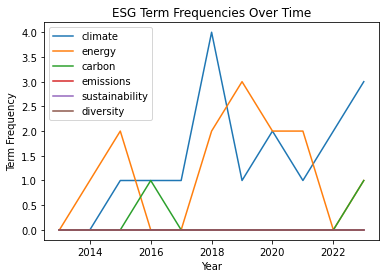

In [13]:
import matplotlib.pyplot as plt

# Example ESG-related terms
esg_terms = ['climate', 'energy', 'carbon', 'emissions', 'sustainability', 'diversity']

# Calculate term frequencies for each year
term_frequencies = {term: [] for term in esg_terms}
years = sorted(lda_models.keys())

for year in years:
    lda = lda_models[year]
    for term in esg_terms:
        term_frequency = sum(term in terms for topic_id in range(lda.num_topics) for terms, _ in lda.show_topic(topic_id))
        term_frequencies[term].append(term_frequency)

# Plot term frequencies
for term, frequencies in term_frequencies.items():
    plt.plot(years, frequencies, label=term)

plt.legend()
plt.xlabel('Year')
plt.ylabel('Term Frequency')
plt.title('ESG Term Frequencies Over Time')
plt.show()


C:\Users\quint\anaconda3\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\quint\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Year: 2013.0
Top words for Topic #1:
{'specie': 0.010678393, 'polar': 0.008211752, 'bear': 0.008058005, 'fws': 0.0080432845, 'court': 0.007822632, 'listing': 0.0071052634, 'agency': 0.0059111994, 'esa': 0.0055663264, 'population': 0.005317976, 'rule': 0.0049024876}


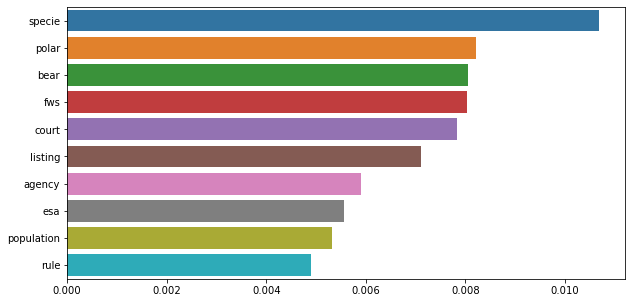

Top words for Topic #2:
{'court': 0.009096169, 'case': 0.006664638, 'see': 0.0065209595, 'plaintiff': 0.006424249, 'agency': 0.0063871136, 'document': 0.005690007, 'state': 0.00568877, 'filed': 0.0052738064, 'page': 0.0050732396, 'action': 0.0045177783}


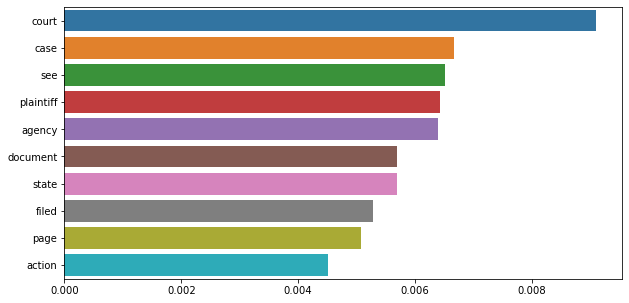

Top words for Topic #3:
{'epa': 0.01290173, 'air': 0.009672094, 'state': 0.0074314517, 'rule': 0.006448615, 'regulation': 0.0058358456, 'gas': 0.0055358973, 'emission': 0.0050691557, 'pollutant': 0.0042967424, 'greenhouse': 0.00427773, 'source': 0.004169344}


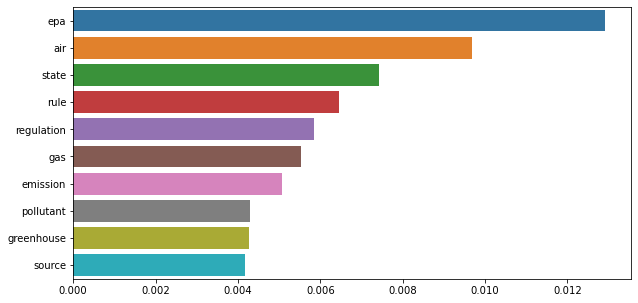

Top words for Topic #4:
{'system': 0.012945548, 'program': 0.009425236, 'document': 0.007486732, 'water': 0.0072437404, 'page': 0.0071021183, 'case': 0.0064145913, 'day': 0.0061126603, 'sewer': 0.0059816977, 'entered': 0.0055961595, 'docket': 0.005477252}


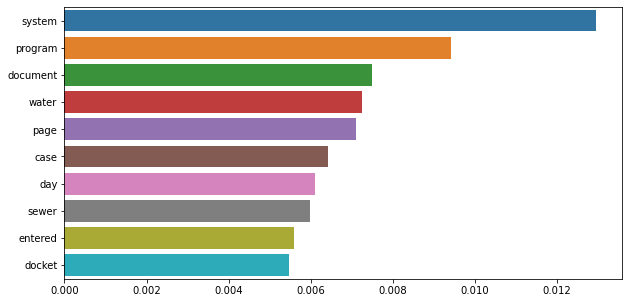

Top words for Topic #5:
{'state': 0.006683173, 'emission': 0.0058794036, 'court': 0.0058194133, 'see': 0.0055665546, 'fuel': 0.004318016, 'impact': 0.00407673, 'page': 0.0037635579, 'would': 0.0037616643, 'standard': 0.003600978, 'california': 0.0035426116}


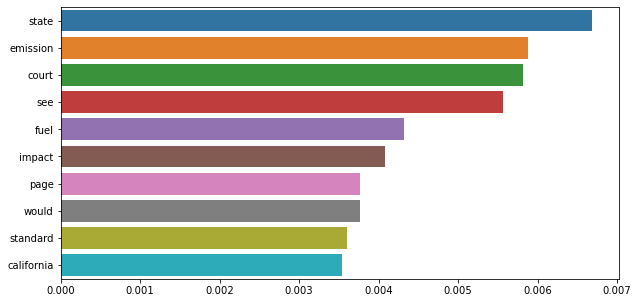

Top words for Topic #6:
{'fuel': 0.015259798, 'vehicle': 0.01072162, 'epa': 0.009918095, 'waiver': 0.008977391, 'e15': 0.008951684, 'emission': 0.0073758313, 'motor': 0.006501075, 'use': 0.004994118, 'standing': 0.004971748, 'ethanol': 0.004622065}


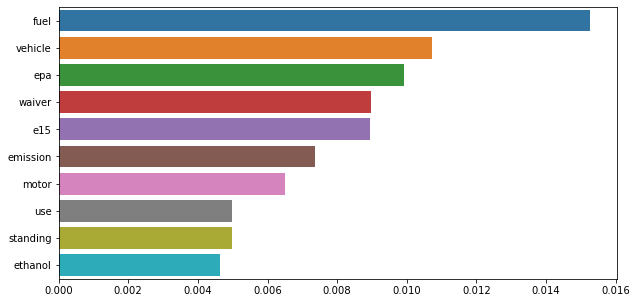

Top words for Topic #7:
{'subpart': 0.009765378, 'emission': 0.007706419, 'reporting': 0.0076087164, 'epa': 0.0073018433, 'gas': 0.0072690356, 'section': 0.0071898196, 'rule': 0.0069980575, 'proposed': 0.0065619405, 'paragraph': 0.006312196, 'facility': 0.0057375324}


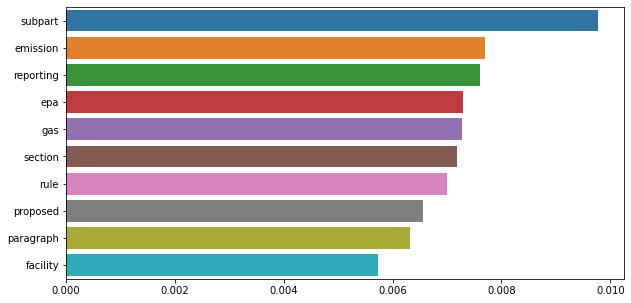

Top words for Topic #8:
{'project': 0.017238421, 'eir': 0.010633495, 'city': 0.010146129, 'impact': 0.009048566, 'plan': 0.007885853, 'ceqa': 0.0073662866, 'alternative': 0.0073214043, 'court': 0.0066845166, 'public': 0.0061840564, 'environmental': 0.0054394826}


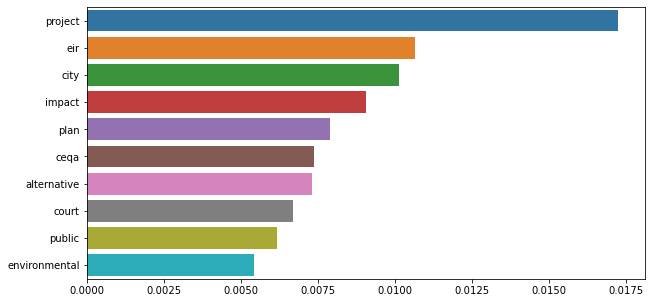

Top words for Topic #9:
{'volume': 0.016098162, 'biofuel': 0.012552477, 'cellulosic': 0.009343817, 'production': 0.008857881, 'fuel': 0.008766295, 'ethanol': 0.007366606, 'renewable': 0.006637082, 'advanced': 0.0059575886, 'would': 0.0058120457, 'facility': 0.0057981983}


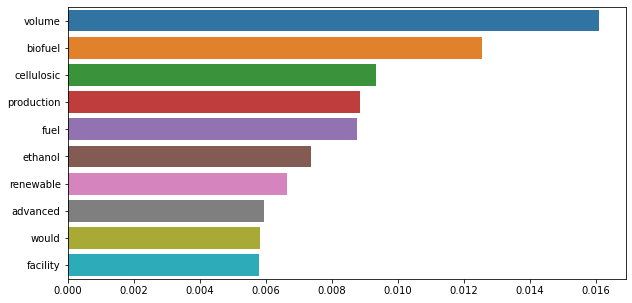

Top words for Topic #10:
{'state': 0.013382851, 'ocean': 0.012477453, 'water': 0.011447615, 'acidification': 0.007883106, 'court': 0.006871036, 'petition': 0.0063829217, 'united': 0.006212341, 'district': 0.004322275, 'quality': 0.003838113, 'denied': 0.0037474942}


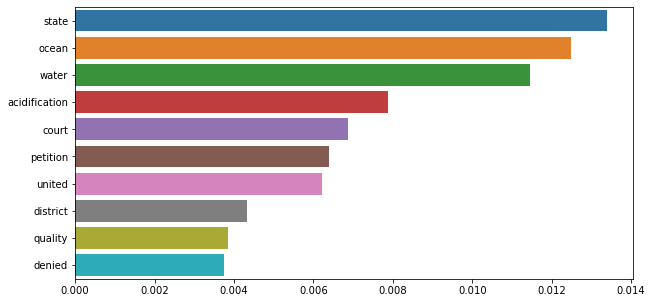

Year: 2014.0
Top words for Topic #1:
{'environmental': 0.0057796873, 'agency': 0.005533612, 'impact': 0.0050636525, 'action': 0.005049777, 'water': 0.0049223294, 'case': 0.0048573343, 'epa': 0.004774379, 'gas': 0.0047281855, 'state': 0.004503952, 'page': 0.0042875675}


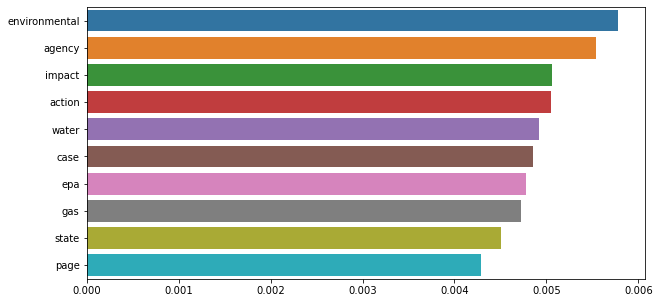

Top words for Topic #2:
{'doe': 0.014400057, 'equipment': 0.013795703, 'cost': 0.009183652, 'standard': 0.008621943, 'energy': 0.0075224726, 'test': 0.0065483893, 'rule': 0.0062631154, 'commercial': 0.0059368634, 'case': 0.0053545763, 'procedure': 0.005087738}


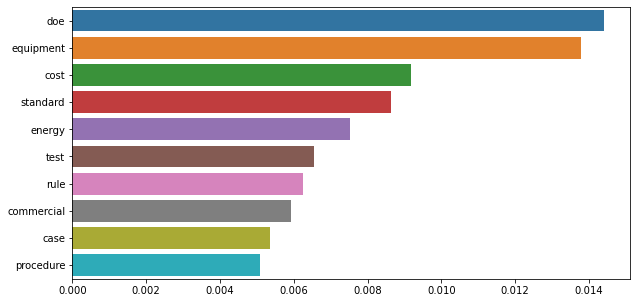

Top words for Topic #3:
{'court': 0.009346554, 'state': 0.008551027, 'public': 0.0068609403, 'defendant': 0.0061512855, 'plaintiff': 0.005739558, 'shall': 0.005608795, 'service': 0.005520296, 'united': 0.004868069, 'utility': 0.0045009786, 'case': 0.004039951}


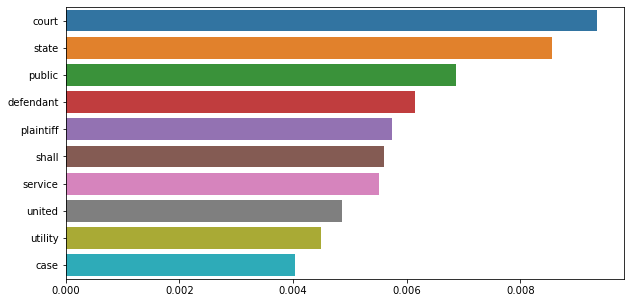

Top words for Topic #4:
{'barclays': 0.015661668, 'tricorona': 0.009999034, 'project': 0.008098301, 'cfp': 0.00716018, 'would': 0.0058917576, 'information': 0.0058143777, 'partner': 0.00528203, 'cer': 0.004585262, 'portfolio': 0.004057143, 'patel': 0.003949701}


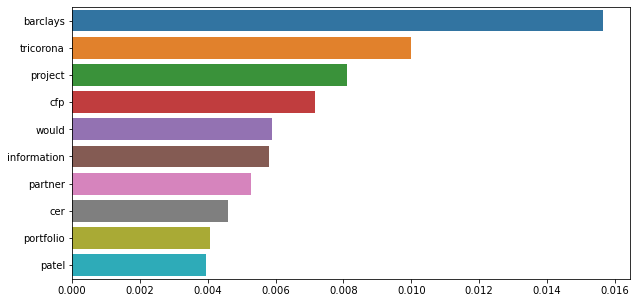

Top words for Topic #5:
{'project': 0.014073933, 'impact': 0.010444163, 'eir': 0.0065084305, 'plan': 0.005686046, 'would': 0.0056725163, 'environmental': 0.005641636, 'agency': 0.0046228287, 'section': 0.0045960946, 'public': 0.0043441663, 'state': 0.004230273}


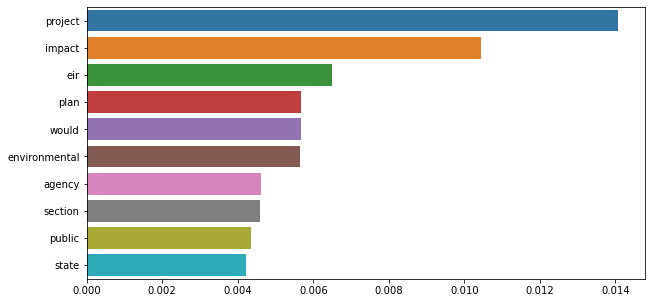

Top words for Topic #6:
{'theâ': 0.021807257, 'toâ': 0.01295157, 'andâ': 0.0101115, 'thatâ': 0.0086591225, 'ofâ': 0.008118574, 'court': 0.0062531317, 'isâ': 0.005357455, 'inâ': 0.0051766117, 'forest': 0.004991579, 'corp': 0.004838023}


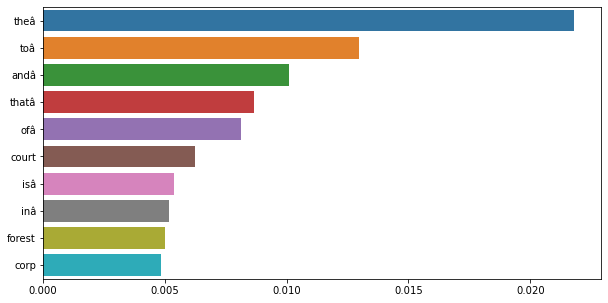

Top words for Topic #7:
{'defendant': 0.03792448, 'plaintiff': 0.030367034, 'sewer': 0.028225183, 'property': 0.023787843, 'water': 0.018044364, 'andor': 0.014718678, 'village': 0.009907401, 'invasion': 0.009529581, 'proximately': 0.008221614, 'directly': 0.008072157}


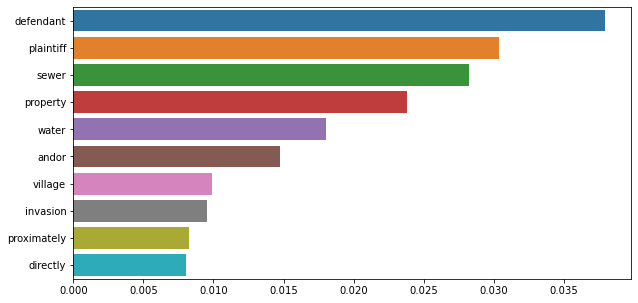

Top words for Topic #8:
{'document': 0.014407488, 'epa': 0.01418157, 'record': 0.009785437, 'foia': 0.008054513, 'email': 0.0072413343, 'court': 0.006951649, 'request': 0.006540832, 'agency': 0.006413377, 'search': 0.0056133457, 'case': 0.004007239}


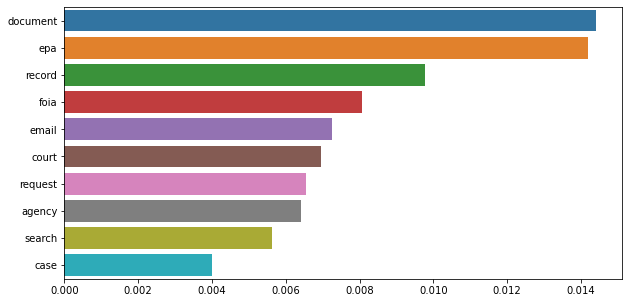

Top words for Topic #9:
{'state': 0.0213904, 'emission': 0.012929268, 'epa': 0.011705917, 'plan': 0.010731725, 'egus': 0.006034097, 'requirement': 0.005782317, 'section': 0.0055772406, 'rule': 0.0053913877, 'affected': 0.0052593127, 'would': 0.0052485764}


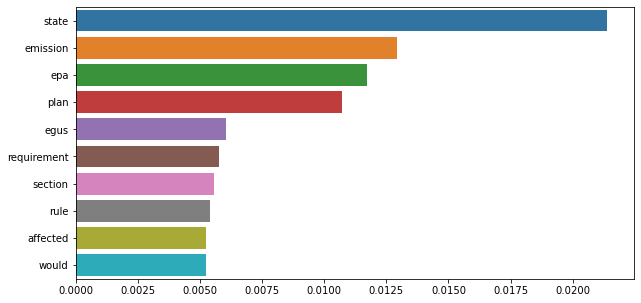

Top words for Topic #10:
{'epa': 0.014828026, 'emission': 0.0072384896, 'court': 0.0071685137, 'standard': 0.0061555034, 'section': 0.006105069, 'air': 0.005914987, 'see': 0.0055564786, 'state': 0.0050557903, 'rule': 0.0049465615, 'source': 0.004925879}


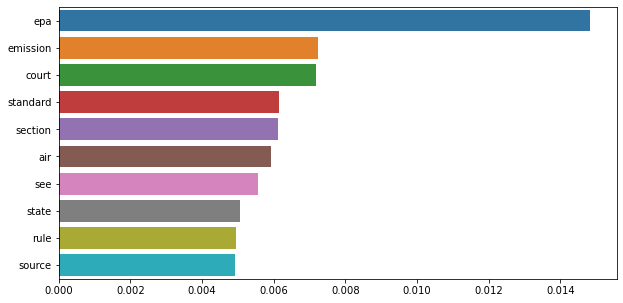

Year: 2015.0
Top words for Topic #1:
{'permit': 0.0073128017, 'plaintiff': 0.0070063914, 'dkt': 0.0068319403, 'regulation': 0.006253476, 'blm': 0.00544255, 'court': 0.0051351343, 'project': 0.0050998335, 'would': 0.0041902703, 'agency': 0.0040205037, 'action': 0.003956053}


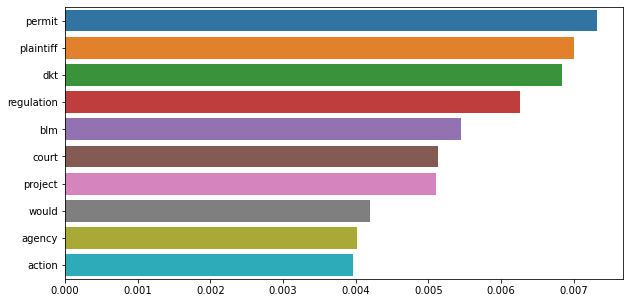

Top words for Topic #2:
{'power': 0.016003901, 'state': 0.014025949, 'case': 0.010227142, 'energy': 0.009759307, 'page': 0.009451635, 'plan': 0.009325886, 'filed': 0.008787381, 'document': 0.008622378, 'epa': 0.008420571, 'emission': 0.0074404497}


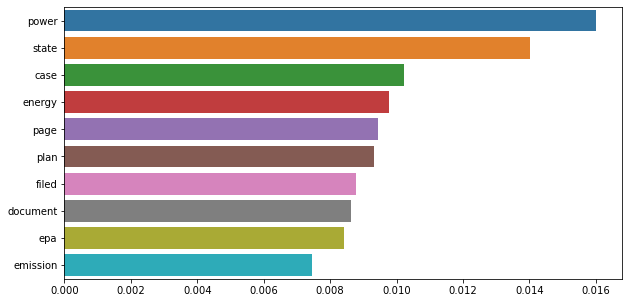

Top words for Topic #3:
{'doe': 0.017967027, 'equipment': 0.015620211, 'standard': 0.011041406, 'cost': 0.009278178, 'energy': 0.0085688485, 'rule': 0.00836771, 'analysis': 0.006097083, 'commercial': 0.0056164917, 'case': 0.005043695, 'final': 0.0050124335}


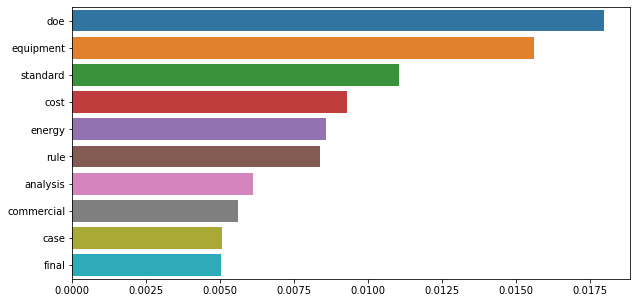

Top words for Topic #4:
{'fuel': 0.023144076, 'volume': 0.01421694, 'renewable': 0.012416187, 'standard': 0.009239181, 'biofuel': 0.007793807, 'epa': 0.006563294, 'requirement': 0.0065320954, 'would': 0.0061028227, 'rins': 0.0059821475, 'production': 0.0059051462}


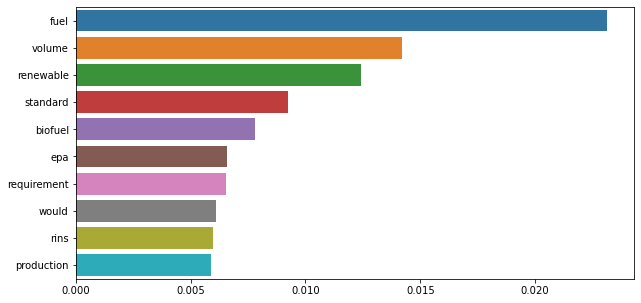

Top words for Topic #5:
{'case': 0.008035266, 'filed': 0.007245583, 'page': 0.007005782, 'coal': 0.006981707, 'wolverine': 0.0069098873, 'rule': 0.006779566, 'see': 0.0061974907, 'state': 0.005562001, 'document': 0.0054621045, 'plan': 0.005109473}


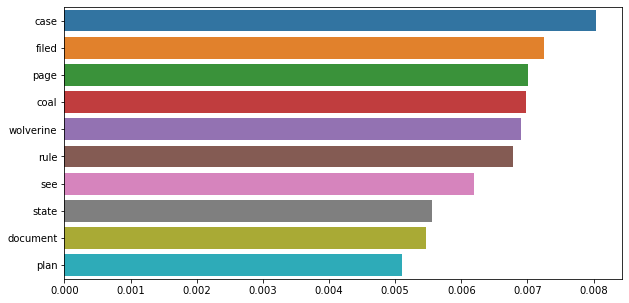

Top words for Topic #6:
{'case': 0.009739381, 'state': 0.008933484, 'page': 0.008076202, 'document': 0.006582783, 'filed': 0.006524415, 'court': 0.005314586, 'climate': 0.005271281, 'emission': 0.0042950027, 'environmental': 0.004237447, 'rule': 0.0040998133}


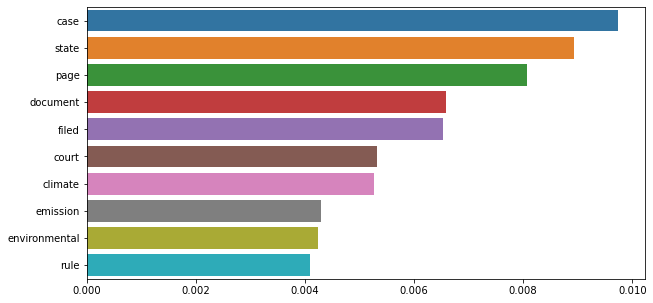

Top words for Topic #7:
{'agency': 0.00829212, 'court': 0.007258334, 'action': 0.006973344, 'project': 0.006080021, 'state': 0.005728162, 'gas': 0.0055515952, 'impact': 0.0055267704, 'epa': 0.0054675546, 'environmental': 0.005158337, 'filed': 0.005089032}


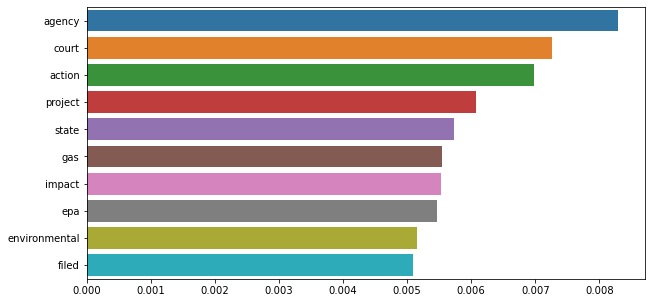

Top words for Topic #8:
{'rule': 0.021958293, 'state': 0.018104676, 'epa': 0.010833844, 'plan': 0.007990402, 'texas': 0.006771602, 'section': 0.006660888, 'agency': 0.0053033563, 'emission': 0.0052772304, 'power': 0.0046768724, 'source': 0.004672942}


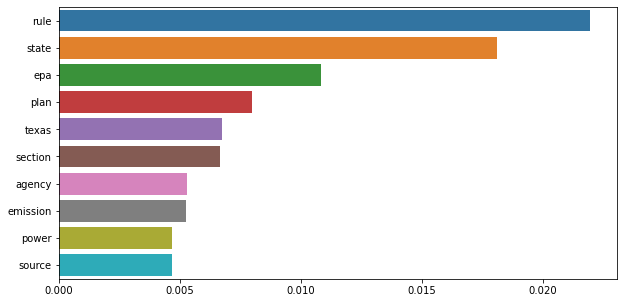

Top words for Topic #9:
{'court': 0.00991187, 'see': 0.007138861, 'state': 0.0067760246, 'plaintiff': 0.006746885, 'case': 0.005674415, 'claim': 0.0046741767, 'f3d': 0.0046360926, 'also': 0.004050824, 'greenpeace': 0.003977984, 'fws': 0.0039155255}


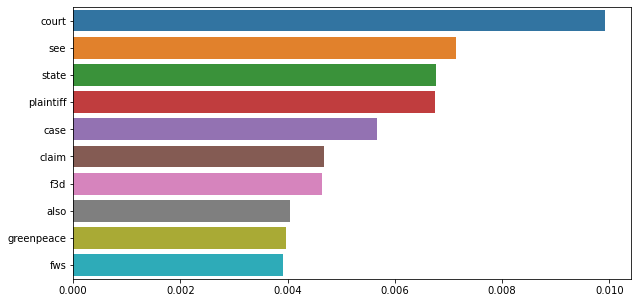

Top words for Topic #10:
{'project': 0.0115775755, 'impact': 0.007269559, 'water': 0.006911663, 'court': 0.005856435, 'environmental': 0.0057109045, 'county': 0.0050960593, 'plan': 0.004921304, 'public': 0.0048136315, 'state': 0.0044795447, 'area': 0.0039283605}


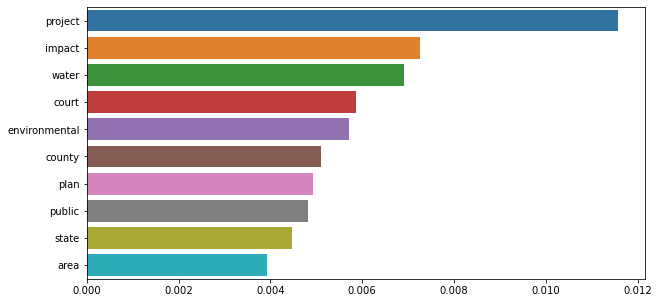

Year: 2016.0
Top words for Topic #1:
{'fuel': 0.011960771, 'state': 0.006784108, 'court': 0.0062450445, 'case': 0.0059295814, 'see': 0.0045861304, 'oregon': 0.004317628, 'program': 0.004198226, 'would': 0.0040912107, 'emission': 0.0040093334, 'carbon': 0.0038205201}


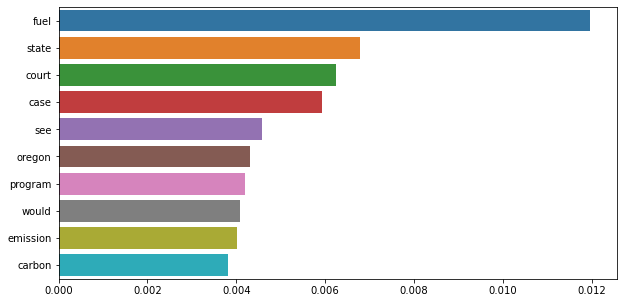

Top words for Topic #2:
{'epa': 0.013256329, 'ferc': 0.0062830346, 'impact': 0.006248673, 'project': 0.006070486, 'case': 0.0060052997, 'agency': 0.0057764533, 'document': 0.005420002, 'pipeline': 0.005351484, 'gas': 0.0051725376, 'environmental': 0.005117137}


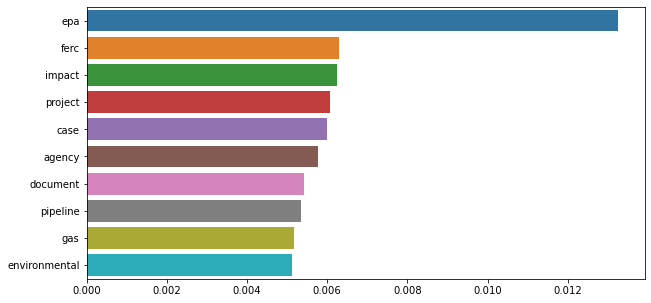

Top words for Topic #3:
{'attorney': 0.010762639, 'general': 0.010043512, 'state': 0.009755627, 'document': 0.0077358666, 'page': 0.0064949477, 'case': 0.0053530517, 'filed': 0.0051418026, 'section': 0.004843792, 'counsel': 0.004840586, 'climate': 0.0044753468}


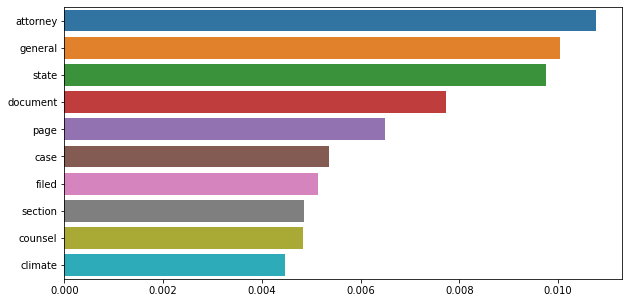

Top words for Topic #4:
{'epa': 0.009763054, 'emission': 0.007630673, 'section': 0.007144114, 'requirement': 0.005978344, 'refrigerant': 0.005542207, 'shall': 0.005289102, 'must': 0.004865468, 'rule': 0.0047392105, 'state': 0.004704904, 'may': 0.0043555107}


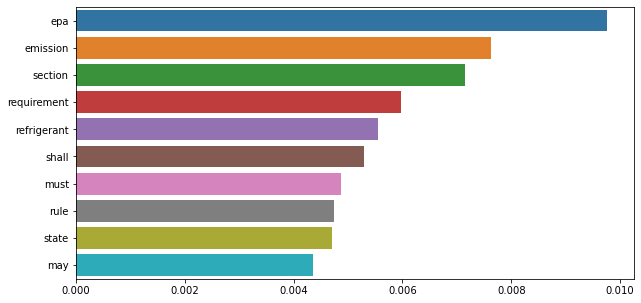

Top words for Topic #5:
{'impact': 0.011690001, 'gas': 0.011627606, 'would': 0.0073649967, 'environmental': 0.0071845287, 'alternative': 0.006398841, 'project': 0.0054812143, 'nepa': 0.0054006143, 'lease': 0.005382071, 'coal': 0.0052774674, 'export': 0.0051974324}


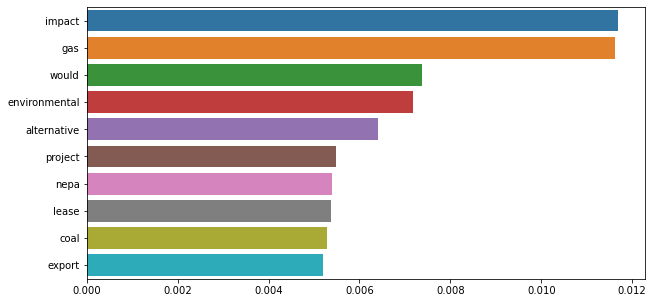

Top words for Topic #6:
{'specie': 0.010119232, 'habitat': 0.0075823716, 'service': 0.00728519, 'action': 0.007240071, 'plaintiff': 0.0063278126, 'agency': 0.006125191, 'population': 0.00523997, 'case': 0.004966939, 'defendant': 0.0049396227, 'court': 0.004728148}


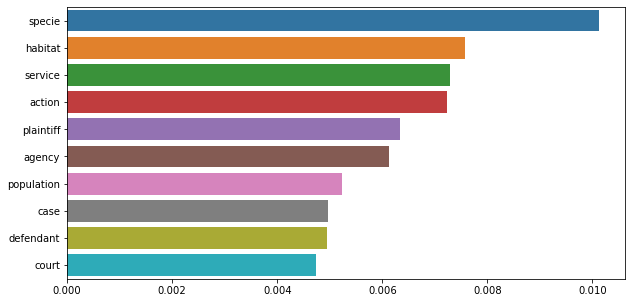

Top words for Topic #7:
{'court': 0.016050909, 'state': 0.013063018, 'case': 0.008181221, 'document': 0.0072978595, 'attorney': 0.0072318357, 'see': 0.0071047437, 'general': 0.006588374, 'filed': 0.0059813634, 'cir': 0.005184878, 'page': 0.004995423}


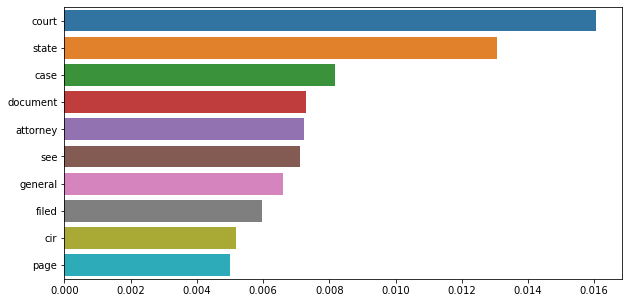

Top words for Topic #8:
{'epa': 0.014559626, 'state': 0.009770722, 'emission': 0.008699536, 'power': 0.007940136, 'cost': 0.006892898, 'unit': 0.0061844885, 'new': 0.006093448, 'standard': 0.006070348, 'rule': 0.00594765, 'case': 0.005716876}


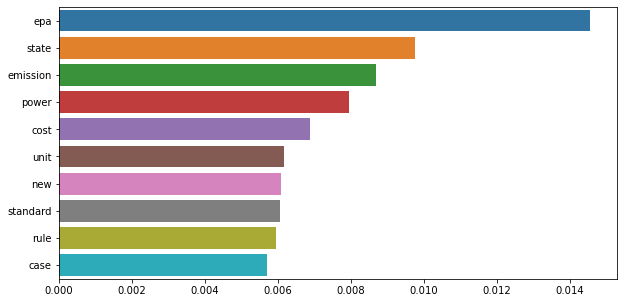

Top words for Topic #9:
{'project': 0.014709932, 'theâ': 0.014152194, 'impact': 0.008274221, 'eir': 0.0073172534, 'ofâ': 0.0071135615, 'plan': 0.0066565657, 'city': 0.0054780506, 'petitioner': 0.004920507, 'toâ': 0.004773884, 'environmental': 0.004659188}


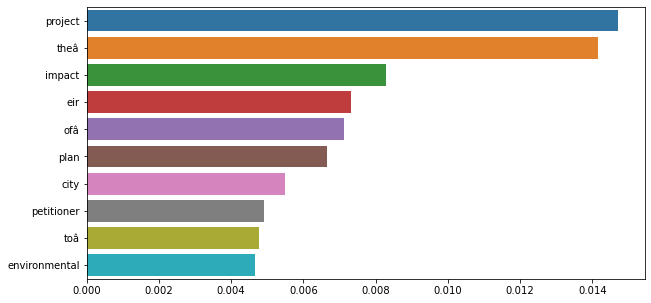

Top words for Topic #10:
{'allegation': 0.01033699, 'paragraph': 0.008834097, 'complaint': 0.008597795, 'amended': 0.0072033303, 'salmon': 0.007114681, 'deny': 0.0066830106, 'right': 0.005771825, 'factual': 0.0057554264, 'fda': 0.0057066507, 'case': 0.005538409}


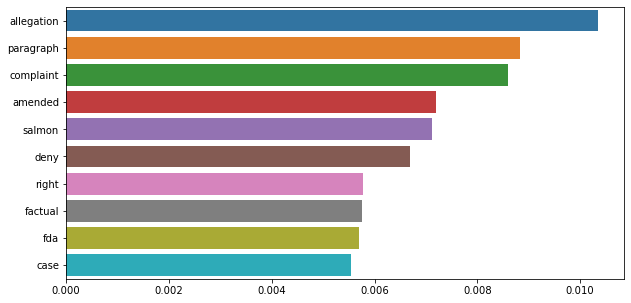

Year: 2017.0
Top words for Topic #1:
{'gas': 0.006611438, 'section': 0.006253032, 'case': 0.0058208304, 'environmental': 0.005412185, 'shall': 0.0053668013, 'doe': 0.005363243, 'impact': 0.005271404, 'emission': 0.005216226, 'export': 0.0051298346, 'state': 0.0046645734}


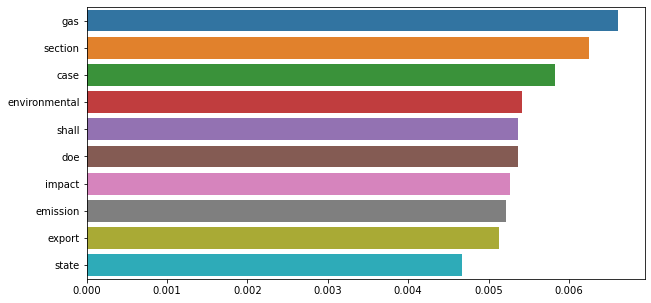

Top words for Topic #2:
{'fuel': 0.008750216, 'volume': 0.0071100947, 'renewable': 0.006604154, 'greenpeace': 0.006252605, 'resolute': 0.0060606427, 'epa': 0.004829004, 'forest': 0.004576936, 'standard': 0.0044780727, 'biodiesel': 0.00443322, 'case': 0.0042947913}


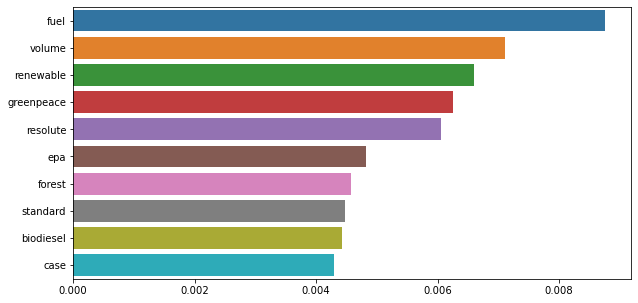

Top words for Topic #3:
{'climate': 0.012011571, 'change': 0.008786, 'fuel': 0.007828487, 'level': 0.0075795427, 'defendant': 0.007488465, 'sea': 0.007439434, 'fossil': 0.0073727574, 'global': 0.0055369306, 'rise': 0.004936244, 'product': 0.004827719}


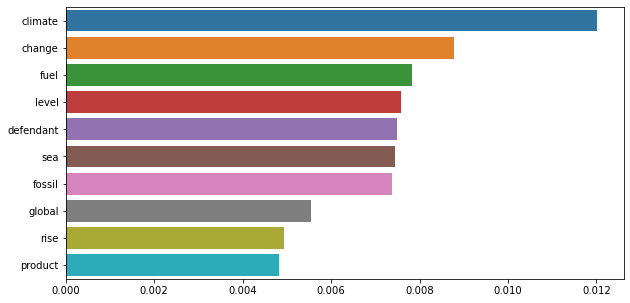

Top words for Topic #4:
{'case': 0.012738477, 'court': 0.012250804, 'state': 0.010792058, 'federal': 0.010379661, 'plaintiff': 0.008902051, 'claim': 0.0071595865, 'document': 0.007000539, 'see': 0.006647735, 'filed': 0.0064802105, 'cir': 0.006330337}


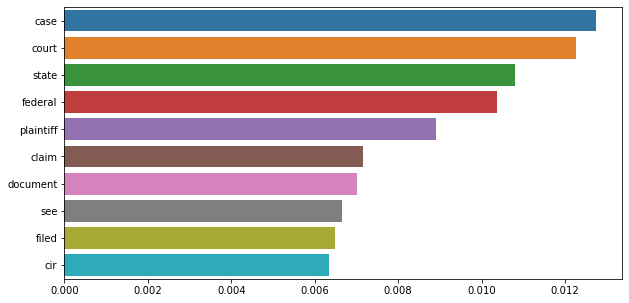

Top words for Topic #5:
{'rule': 0.011485328, 'epa': 0.009720508, 'state': 0.008382373, 'case': 0.008274216, 'emission': 0.008074195, 'agency': 0.006920868, 'document': 0.0064916345, 'standard': 0.006375317, 'filed': 0.0060123424, 'gas': 0.005359426}


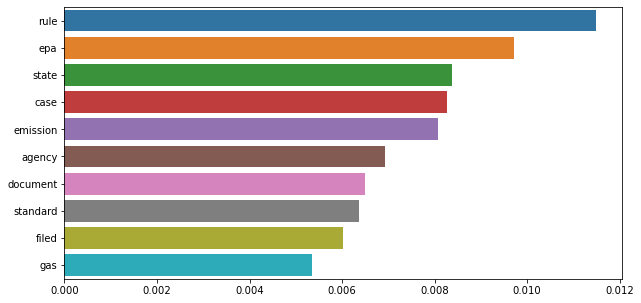

Top words for Topic #6:
{'city': 0.012181458, 'oil': 0.0075280755, 'state': 0.006714872, 'case': 0.006336485, 'court': 0.006287443, 'ordinance': 0.005570065, 'coal': 0.0054684044, 'page': 0.0043940004, 'filed': 0.0043058777, 'pplc': 0.004226448}


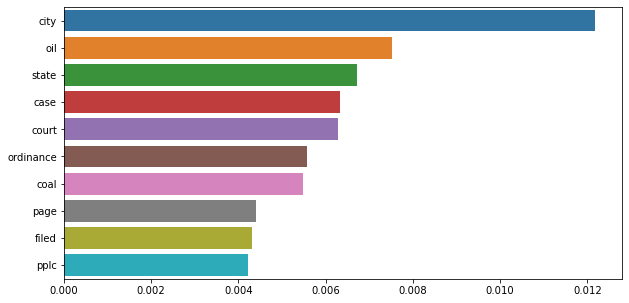

Top words for Topic #7:
{'court': 0.0068014665, 'filed': 0.0053749667, 'section': 0.0053379256, 'case': 0.005099387, 'colorado': 0.0050221086, 'page': 0.004188106, 'state': 0.0040846923, 'right': 0.0040740506, 'document': 0.004016108, 'act': 0.0038121594}


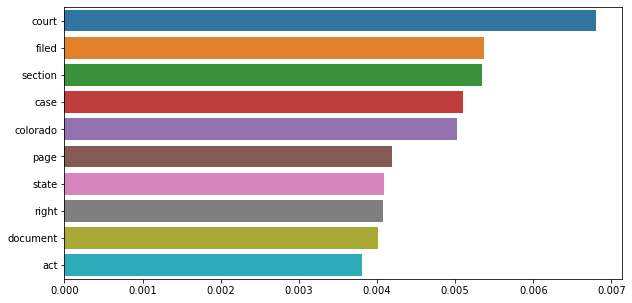

Top words for Topic #8:
{'project': 0.011447421, 'impact': 0.010251287, 'gas': 0.007868006, 'ferc': 0.0075696115, 'environmental': 0.007539562, 'pipeline': 0.0064654644, 'would': 0.00634748, 'agency': 0.0057061682, 'water': 0.005497498, 'case': 0.0054155462}


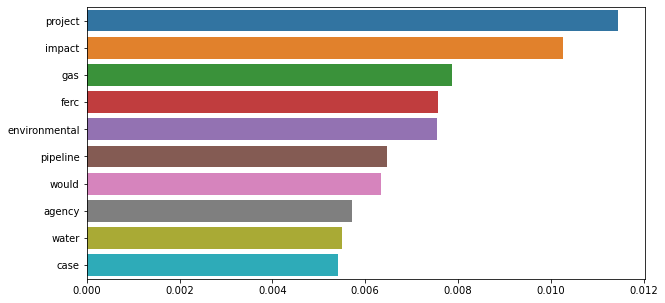

Top words for Topic #9:
{'exxon': 0.0097814845, 'document': 0.008738051, 'exxonâ\x80\x99s': 0.0060389186, 'attorney': 0.005860624, 'general': 0.005854717, 'filed': 0.005680521, 'new': 0.00504046, 'cost': 0.0050243563, 'page': 0.00463993, 'defendant': 0.004202852}


C:\Users\quint\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\quint\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 153 (\x99) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


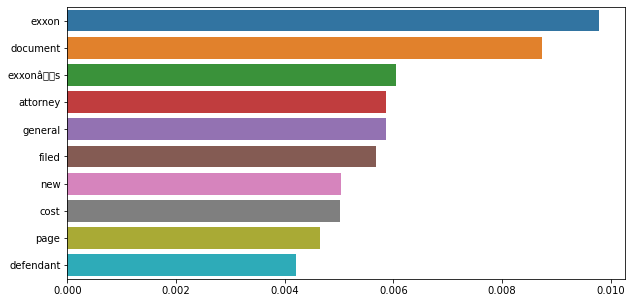

Top words for Topic #10:
{'state': 0.008363716, 'court': 0.0069258125, 'case': 0.0064779045, 'specie': 0.006079871, 'plaintiff': 0.0057699815, 'see': 0.005152806, 'document': 0.004676179, 'wholesale': 0.0044953953, 'page': 0.0043470343, 'zec': 0.0038852121}


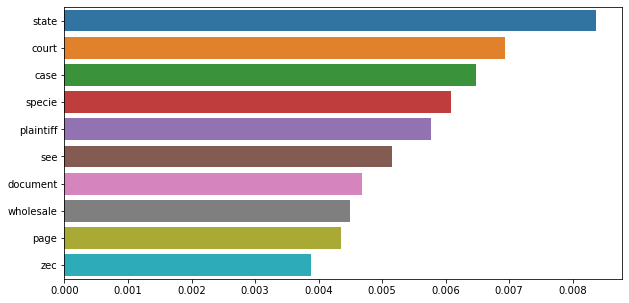

Year: 2018.0
Top words for Topic #1:
{'theâ': 0.018616445, 'andâ': 0.011878912, 'ofâ': 0.011484375, 'toâ': 0.010492629, 'defendant': 0.009596061, 'climate': 0.0068965456, 'paragraph': 0.0064553055, 'allegation': 0.005898882, 'cost': 0.0058296886, 'exxon': 0.005733597}


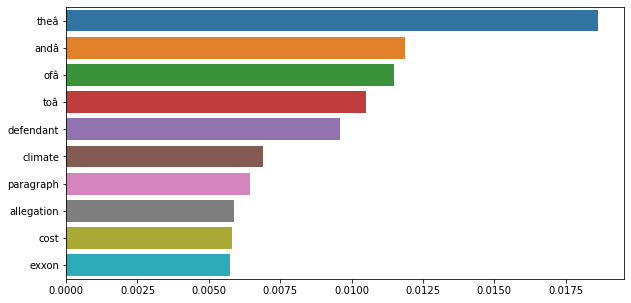

Top words for Topic #2:
{'climate': 0.011881842, 'http': 0.009055196, 'change': 0.008340433, 'document': 0.0076924185, 'storm': 0.0058548367, 'event': 0.005574538, 'energy': 0.0049847346, 'sea': 0.0049383147, 'page': 0.0048244116, 'filed': 0.004795944}


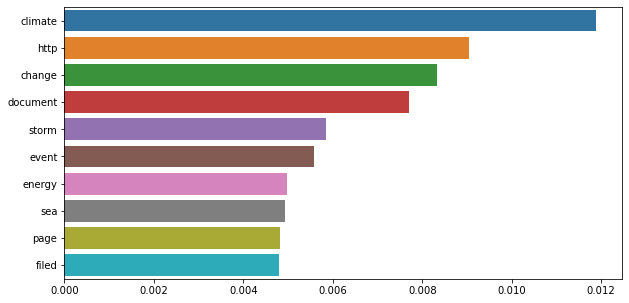

Top words for Topic #3:
{'emission': 0.012890464, 'vehicle': 0.011318528, 'epa': 0.010529961, 'standard': 0.009303856, 'fuel': 0.006050614, 'ghg': 0.0054826876, 'new': 0.005461244, 'glider': 0.004922505, 'would': 0.0045098225, 'manufacturer': 0.0044548977}


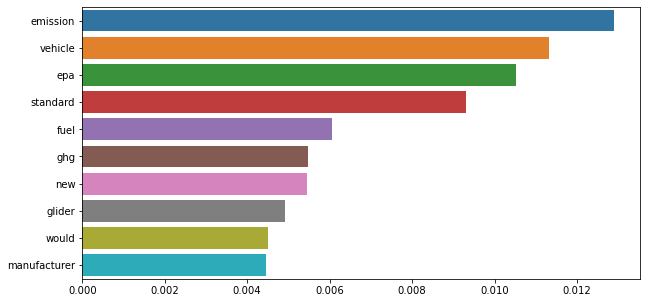

Top words for Topic #4:
{'energy': 0.012372863, 'climate': 0.009691614, 'change': 0.008958914, 'area': 0.0062879105, 'state': 0.0058380784, 'gas': 0.0054220157, 'emission': 0.0051526055, 'page': 0.0049446407, 'document': 0.0049045095, 'impact': 0.0048812605}


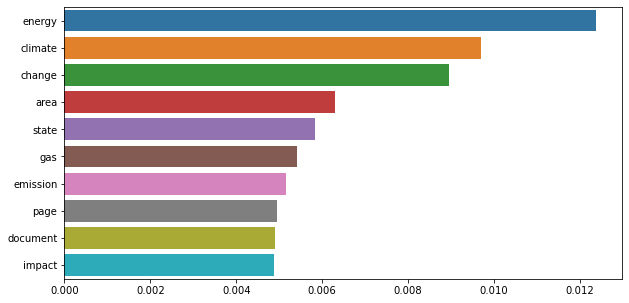

Top words for Topic #5:
{'court': 0.016932413, 'case': 0.013294054, 'state': 0.011713675, 'plaintiff': 0.009299161, 'page': 0.0082034785, 'defendant': 0.008119904, 'document': 0.0074915052, 'federal': 0.007219456, 'filed': 0.007013476, 'motion': 0.0067087314}


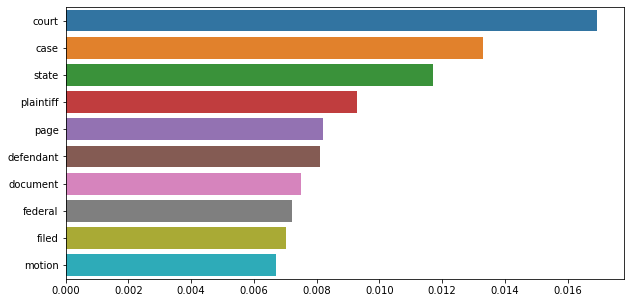

Top words for Topic #6:
{'impact': 0.007011668, 'agency': 0.006858575, 'case': 0.006760355, 'project': 0.0064850063, 'rule': 0.0062987613, 'see': 0.005773033, 'court': 0.0056237495, 'would': 0.005566397, 'page': 0.0051643755, 'document': 0.004922748}


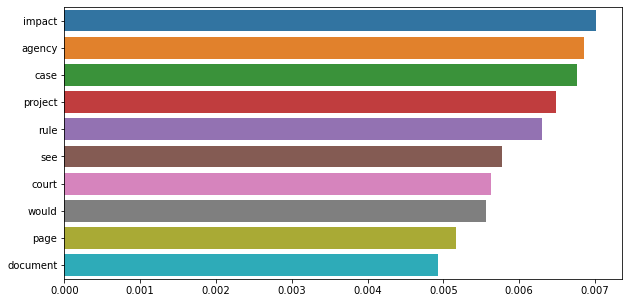

Top words for Topic #7:
{'state': 0.010414601, 'claim': 0.009969478, 'federal': 0.009788598, 'case': 0.009685415, 'law': 0.009460255, 'court': 0.008956081, 'defendant': 0.008249175, 'jurisdiction': 0.006098117, 'f3d': 0.005903274, 'cir': 0.005817745}


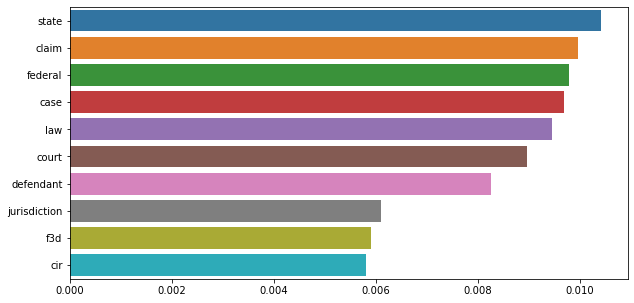

Top words for Topic #8:
{'service': 0.0073051383, 'specie': 0.0059287003, 'pas': 0.0056534735, 'population': 0.00546487, 'habitat': 0.0050827945, 'would': 0.0043392964, 'case': 0.0042326516, 'filed': 0.0040575373, 'page': 0.0039742305, 'document': 0.003966751}


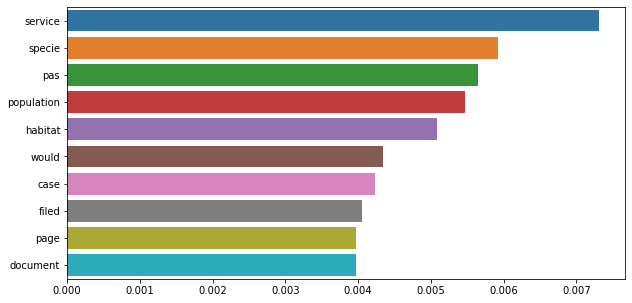

Top words for Topic #9:
{'i255': 0.0767333, 'document': 0.008548908, 'ofâ': 0.008486039, 'def': 0.00805773, 'exxon': 0.0073351986, 'attorney': 0.0072534825, 'general': 0.00684191, 'court': 0.0052607595, 'fact': 0.0050489116, 'climate': 0.0050033554}


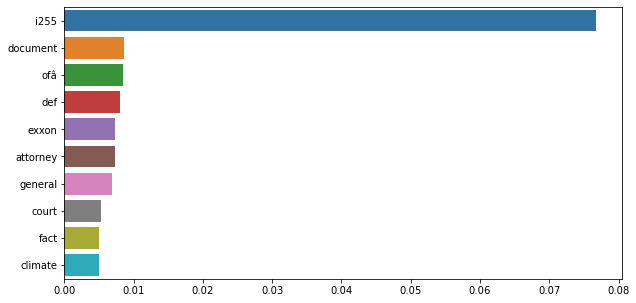

Top words for Topic #10:
{'ferc': 0.010675178, 'commission': 0.00959803, 'project': 0.008790879, 'pipeline': 0.007887236, 'state': 0.0074432017, 'new': 0.007433969, 'order': 0.006245204, 'gas': 0.0059450497, 'certificate': 0.0057618837, 'filed': 0.005440012}


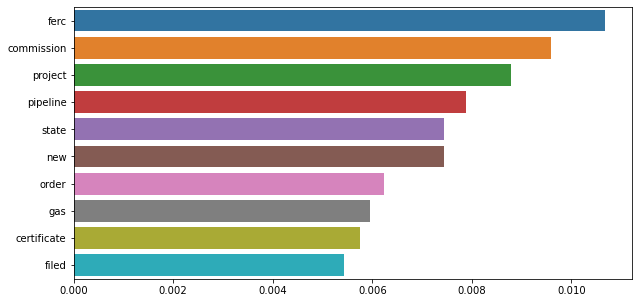

Year: 2019.0
Top words for Topic #1:
{'volume': 0.012009668, 'specie': 0.010016543, 'biofuel': 0.008410947, 'advanced': 0.008223142, 'renewable': 0.0069169845, 'cellulosic': 0.0065554744, 'fuel': 0.0063583623, 'service': 0.0062952973, 'rule': 0.0053884136, 'habitat': 0.005214325}


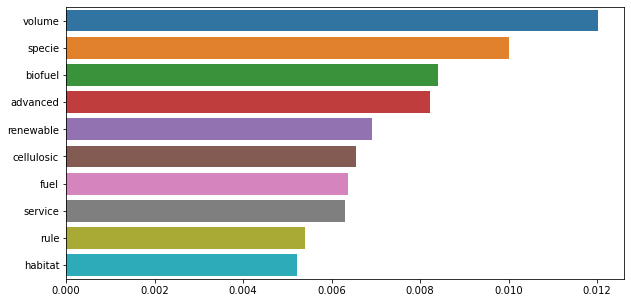

Top words for Topic #2:
{'energy': 0.0110288, 'cost': 0.009401249, 'price': 0.006953681, 'case': 0.0068141273, 'gas': 0.0060839774, 'exxon': 0.005783989, 'state': 0.0053391405, 'page': 0.004875509, 'electricity': 0.004690229, 'exxonâ\x80\x99s': 0.004418211}


C:\Users\quint\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\quint\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 153 (\x99) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


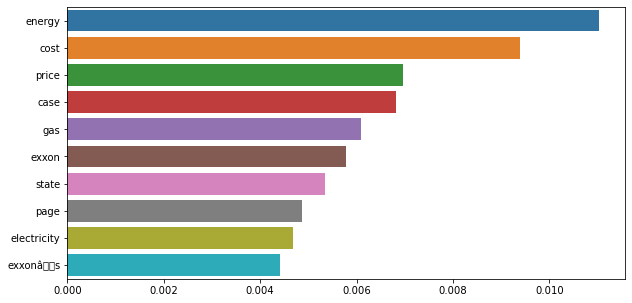

Top words for Topic #3:
{'state': 0.01806053, 'standard': 0.01679848, 'epa': 0.015955219, 'emission': 0.013054714, 'section': 0.01288071, 'plan': 0.00906022, 'regulation': 0.007824801, 'caa': 0.007557806, 'source': 0.0057310597, 'rule': 0.005503823}


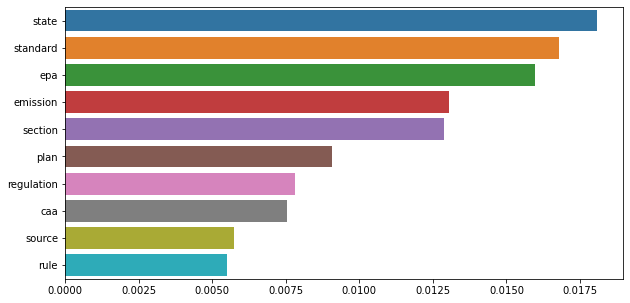

Top words for Topic #4:
{'gas': 0.008282089, 'commission': 0.0064594, 'energy': 0.005956722, 'case': 0.005940287, 'ferc': 0.0054247407, 'natural': 0.004991141, 'order': 0.0047312486, 'public': 0.004506471, 'page': 0.0044255345, 'see': 0.0042694327}


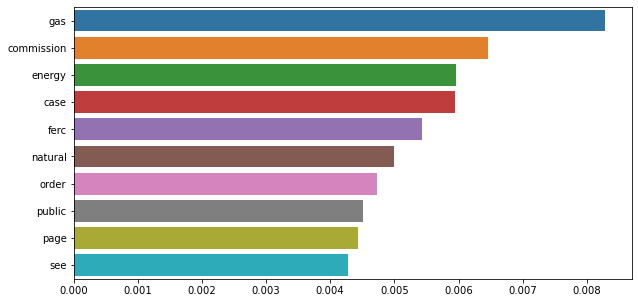

Top words for Topic #5:
{'i255': 0.033005252, 'epa': 0.0265136, 'rule': 0.013492543, 'case': 0.012599206, 'usca': 0.012045819, 'filed': 0.010275999, 'petitioner': 0.009888832, 'fuel': 0.008831537, 'document': 0.008578086, 'page': 0.008181708}


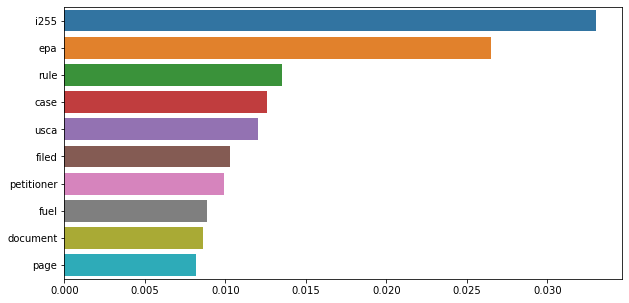

Top words for Topic #6:
{'climate': 0.017721247, 'change': 0.012564872, 'global': 0.007065847, 'emission': 0.0053835437, 'level': 0.0053464733, 'sea': 0.0051215403, 'energy': 0.00477379, 'case': 0.0044628684, 'http': 0.0038674292, 'page': 0.0038526035}


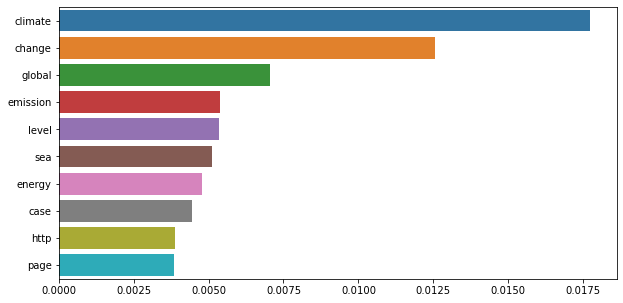

Top words for Topic #7:
{'case': 0.01145772, 'court': 0.01049236, 'state': 0.010480024, 'plaintiff': 0.009504548, 'page': 0.008675199, 'defendant': 0.00690313, 'right': 0.0064753783, 'united': 0.00611833, 'federal': 0.004624075, 'filed': 0.0045187115}


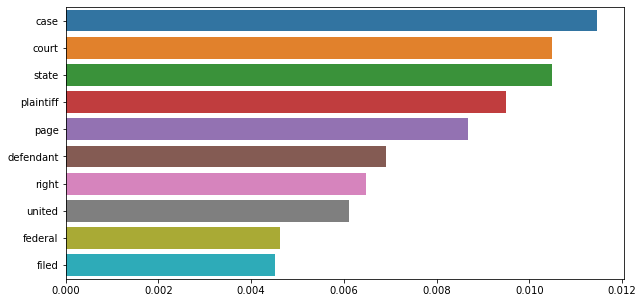

Top words for Topic #8:
{'exxonmobil': 0.011739052, 'new': 0.0070595234, 'penalty': 0.00687927, 'cost': 0.0067351297, 'york': 0.006257309, 'nyscef': 0.005895001, 'civil': 0.00488344, 'nhtsa': 0.004836798, 'model': 0.0047725257, 'would': 0.004767467}


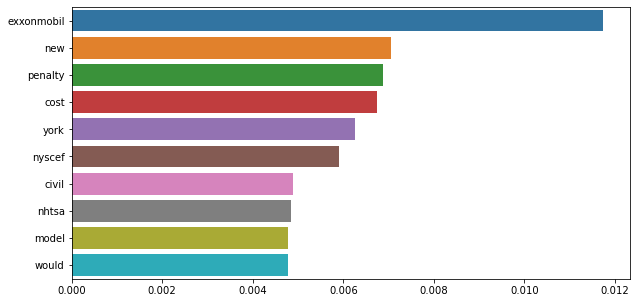

Top words for Topic #9:
{'impact': 0.009042214, 'case': 0.008142698, 'agency': 0.0072064525, 'document': 0.007082473, 'project': 0.0070487563, 'page': 0.0066378065, 'blm': 0.006508689, 'filed': 0.006442448, 'action': 0.0062827435, 'environmental': 0.006247271}


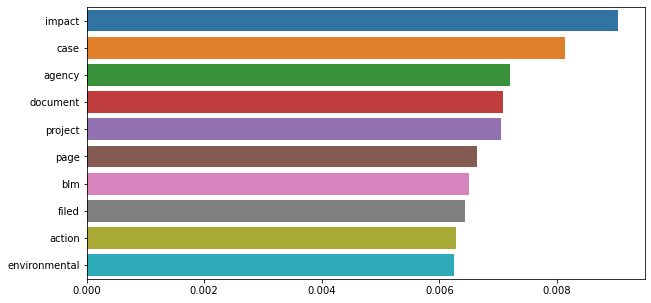

Top words for Topic #10:
{'court': 0.017226666, 'state': 0.016184982, 'federal': 0.01287968, 'case': 0.012626327, 'law': 0.009943666, 'claim': 0.009080409, 'see': 0.0071978997, 'cir': 0.0071256165, 'f3d': 0.006746758, 'defendant': 0.0063645476}


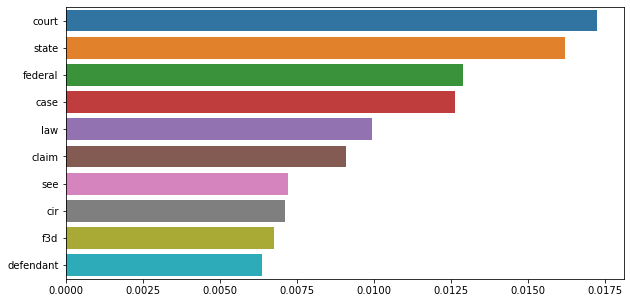

Year: 2020.0
Top words for Topic #1:
{'exxonmobil': 0.007578872, 'cost': 0.0073009306, 'energy': 0.0061619678, 'document': 0.005744069, 'exxon': 0.005451284, 'court': 0.005303755, 'action': 0.0049978714, 'new': 0.0049010585, 'filed': 0.004812619, 'climate': 0.0041898056}


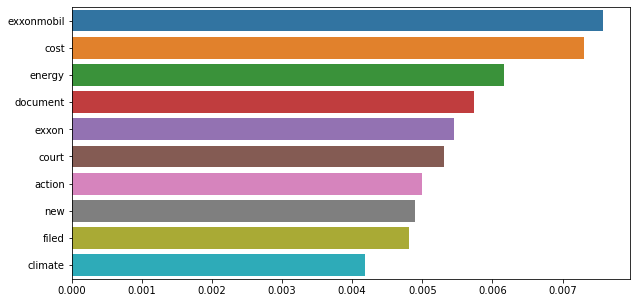

Top words for Topic #2:
{'emission': 0.0105554545, 'epa': 0.0087432675, 'state': 0.008629047, 'case': 0.0078070867, 'fuel': 0.0071426854, 'standard': 0.0069050994, 'climate': 0.0066264262, 'filed': 0.006563276, 'page': 0.0064202566, 'usca': 0.006161326}


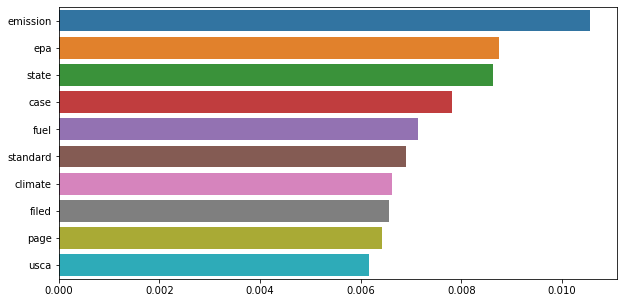

Top words for Topic #3:
{'case': 0.006235282, 'ordinance': 0.006082139, 'state': 0.0056210603, 'energy': 0.005617452, 'filed': 0.0055879, 'document': 0.0054728054, 'shall': 0.0053370288, 'standard': 0.0052385526, 'gas': 0.005090266, 'page': 0.0050539626}


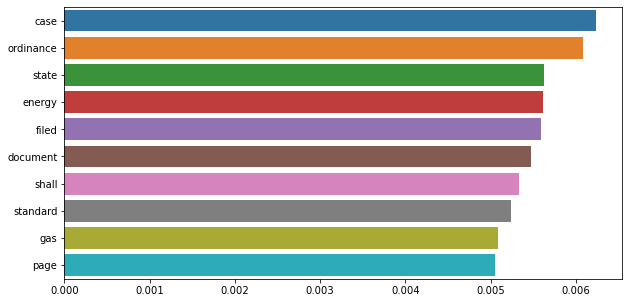

Top words for Topic #4:
{'court': 0.01722271, 'federal': 0.01614657, 'state': 0.012946071, 'case': 0.01186626, 'claim': 0.009093314, 'law': 0.008857699, 'defendant': 0.008119478, 'see': 0.007564432, 'f3d': 0.00595439, 'jurisdiction': 0.0058637233}


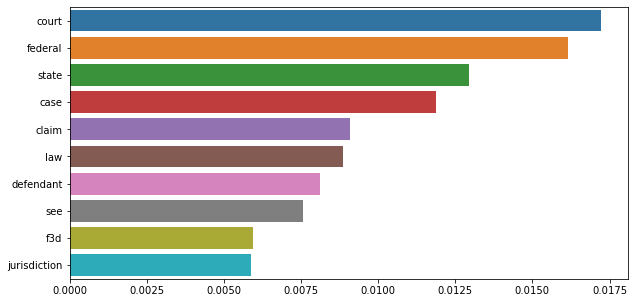

Top words for Topic #5:
{'project': 0.008650077, 'water': 0.007671244, 'state': 0.007545793, 'impact': 0.0067247404, 'would': 0.0056126774, 'delta': 0.004937621, 'court': 0.0048755743, 'environmental': 0.004613314, 'county': 0.0044077123, 'public': 0.00436677}


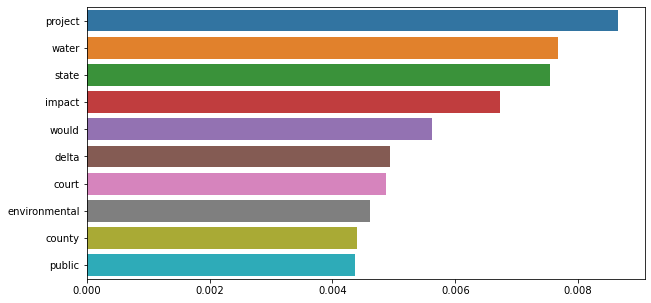

Top words for Topic #6:
{'impact': 0.010207593, 'project': 0.008370206, 'case': 0.007837751, 'action': 0.007816642, 'agency': 0.007581545, 'nepa': 0.0069676894, 'environmental': 0.006819609, 'page': 0.0067939973, 'document': 0.0063323667, 'filed': 0.006007818}


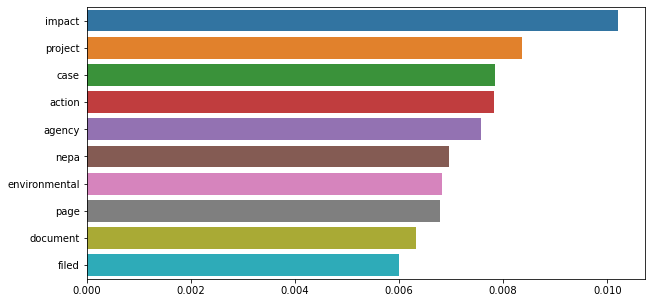

Top words for Topic #7:
{'court': 0.011415001, 'case': 0.009197505, 'see': 0.0076518026, 'rule': 0.0063612056, 'page': 0.0060773776, 'f3d': 0.005880015, 'cir': 0.0058746873, 'agency': 0.0058701104, 'state': 0.0058472888, 'document': 0.0057159998}


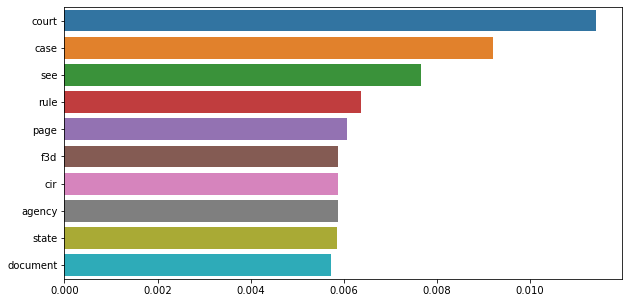

Top words for Topic #8:
{'state': 0.010787161, 'case': 0.009604115, 'ferc': 0.00826724, 'court': 0.007986266, 'pipeline': 0.0074954685, 'order': 0.007198871, 'filed': 0.0066384147, 'page': 0.0065685567, 'commission': 0.005753929, 'document': 0.005440654}


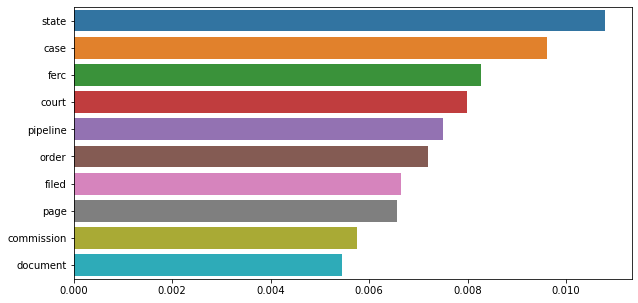

Top words for Topic #9:
{'state': 0.015731895, 'tank': 0.008408817, 'agreement': 0.0078939125, 'car': 0.0067845504, 'united': 0.0063518374, 'california': 0.006114595, 'inc': 0.0054156943, 'case': 0.0053565577, 'foreign': 0.005094542, 'wci': 0.004984529}


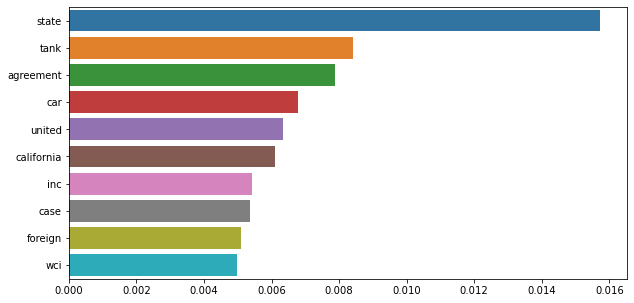

Top words for Topic #10:
{'epa': 0.016665624, 'emission': 0.011527527, 'section': 0.010279927, 'standard': 0.010079521, 'source': 0.010070599, 'rule': 0.009096861, 'gas': 0.008089419, 'requirement': 0.0065274253, 'state': 0.005700247, 'natural': 0.0056632003}


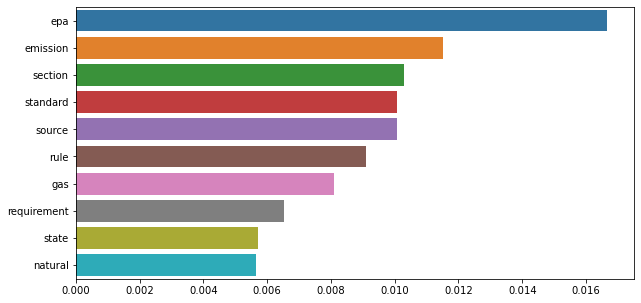

Year: 2021.0
Top words for Topic #1:
{'filed': 0.0069513847, 'gas': 0.006411829, 'page': 0.0063395533, 'document': 0.006302694, 'pipeline': 0.0062640505, 'case': 0.005974824, 'impact': 0.005101694, 'would': 0.0050741644, 'agency': 0.005053779, 'energy': 0.0048821135}


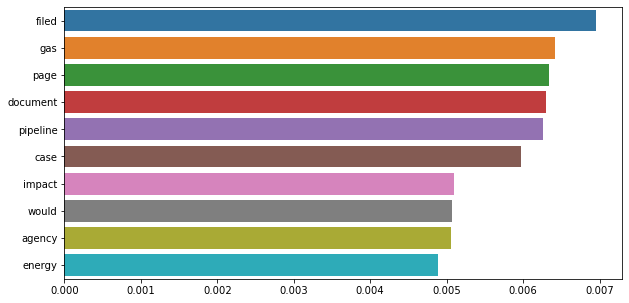

Top words for Topic #2:
{'theâ': 0.01357209, 'plaintiff': 0.008758168, 'defendant': 0.0069394964, 'ofâ': 0.006647741, 'page': 0.0059457417, 'claim': 0.0057137464, 'filed': 0.0052771526, 'toâ': 0.005104751, 'andâ': 0.0050977003, 'plastic': 0.004890018}


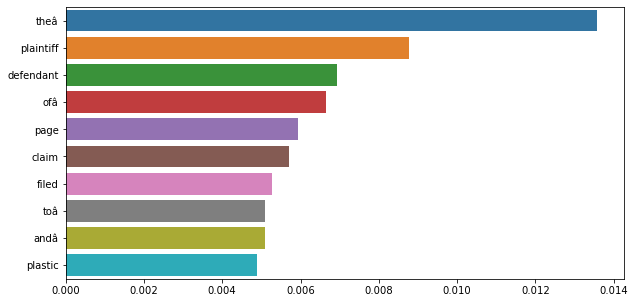

Top words for Topic #3:
{'standard': 0.010703319, 'rule': 0.010543077, 'epa': 0.008991222, 'case': 0.008380482, 'document': 0.0068276315, 'page': 0.006242455, 'filed': 0.005860083, 'doe': 0.0055895555, 'energy': 0.0049497113, 'state': 0.004801682}


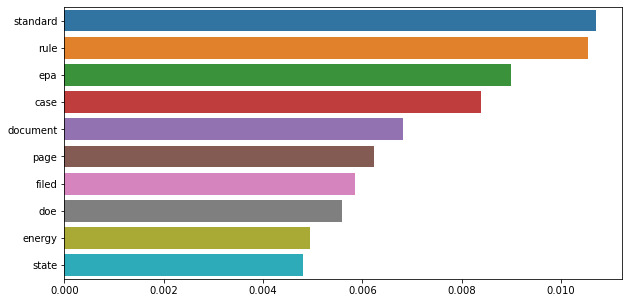

Top words for Topic #4:
{'epa': 0.014873309, 'allowance': 0.012022152, 'hfc': 0.007923625, 'substance': 0.0072531775, 'regulated': 0.0068601314, 'production': 0.006068399, 'year': 0.0052408488, 'emission': 0.0045109973, 'company': 0.0044711814, 'would': 0.0044156}


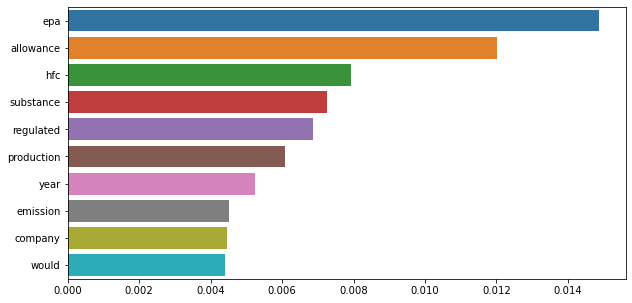

Top words for Topic #5:
{'federal': 0.01672714, 'court': 0.016583014, 'case': 0.013187388, 'state': 0.01222925, 'defendant': 0.0112619, 'claim': 0.009398368, 'law': 0.009276072, 'plaintiff': 0.007046504, 'see': 0.0068554855, 'f3d': 0.006463556}


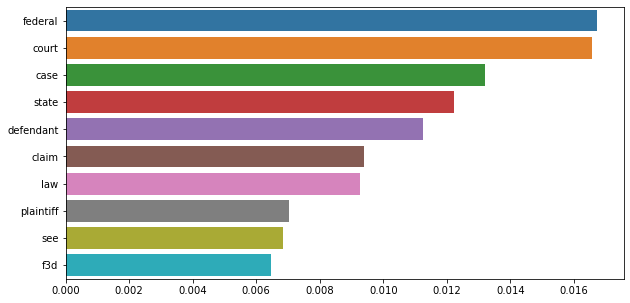

Top words for Topic #6:
{'court': 0.009240278, 'shall': 0.006036068, 'state': 0.005367622, 'public': 0.005262886, 'document': 0.0051274677, 'party': 0.004876856, 'case': 0.004614138, 'data': 0.004574892, 'see': 0.0038350176, 'minn': 0.0037807378}


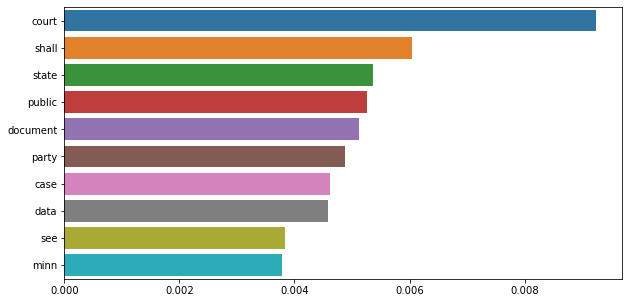

Top words for Topic #7:
{'state': 0.012229624, 'epa': 0.009020559, 'court': 0.007808286, 'power': 0.007731137, 'emission': 0.006680586, 'general': 0.005410389, 'section': 0.005406372, 'see': 0.0053735166, 'source': 0.0053122677, 'rule': 0.004748799}


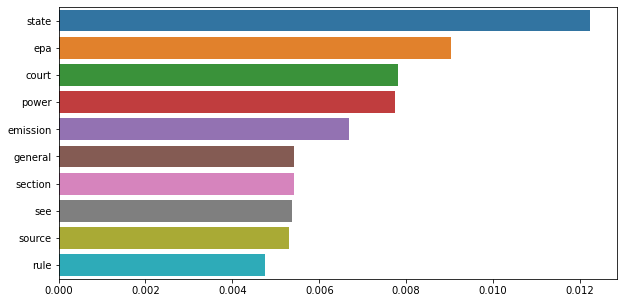

Top words for Topic #8:
{'i255': 0.02491726, 'climate': 0.013277553, 'change': 0.010025101, 'http': 0.007078104, 'impact': 0.0058153933, 'emission': 0.005546283, 'global': 0.0050309594, 'right': 0.0045580314, 'level': 0.004457596, 'sea': 0.003877849}


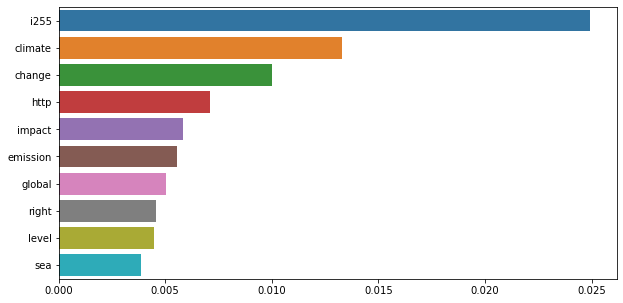

Top words for Topic #9:
{'case': 0.010713217, 'court': 0.0077422773, 'agency': 0.0072670076, 'filed': 0.0068123704, 'page': 0.0067577497, 'plaintiff': 0.0065992847, 'action': 0.0065772594, 'document': 0.0064524924, 'see': 0.0064057186, 'state': 0.006284571}


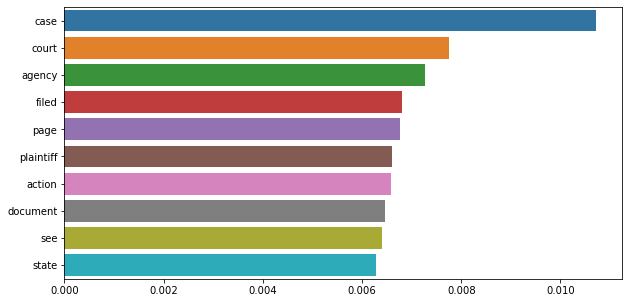

Top words for Topic #10:
{'project': 0.00864756, 'specie': 0.008260665, 'impact': 0.008036994, 'area': 0.0069067096, 'service': 0.0066093113, 'habitat': 0.006443134, 'forest': 0.006342951, 'action': 0.004812859, 'change': 0.0045596417, 'page': 0.0045003355}


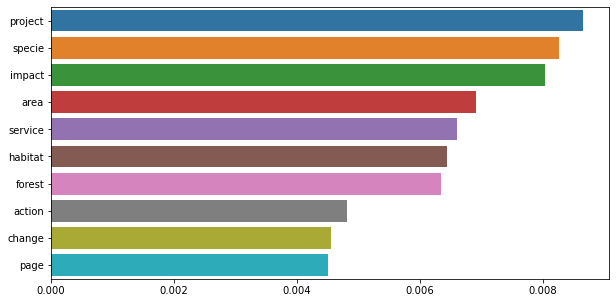

Year: 2022.0
Top words for Topic #1:
{'standard': 0.014399575, 'epa': 0.013545726, 'vehicle': 0.009100372, 'emission': 0.0087863365, 'rule': 0.0084628165, 'section': 0.0065969587, 'cost': 0.0057411366, 'program': 0.0047639557, 'final': 0.0046877926, 'credit': 0.004687195}


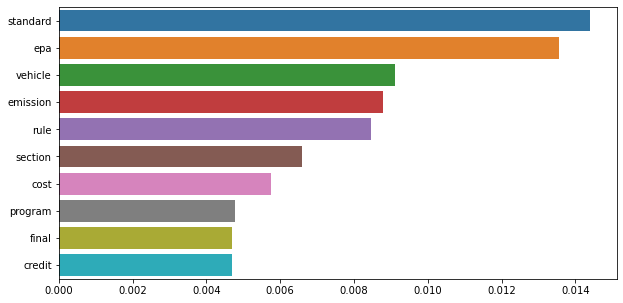

Top words for Topic #2:
{'i255': 0.06039206, 'state': 0.013168191, 'court': 0.009871625, 'case': 0.0061934306, 'filed': 0.005736692, 'power': 0.0056943735, 'see': 0.00542102, 'emission': 0.0050124926, 'new': 0.004841718, 'epa': 0.0046508904}


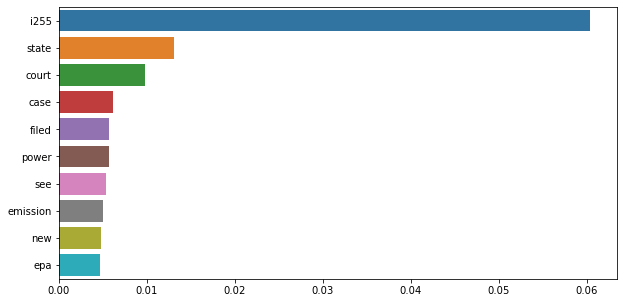

Top words for Topic #3:
{'court': 0.012214814, 'case': 0.009113575, 'rule': 0.008346428, 'plaintiff': 0.008137191, 'see': 0.0064730216, 'filed': 0.0064655007, 'page': 0.0062015085, 'state': 0.0059145987, 'document': 0.0058814646, 'defendant': 0.0057616727}


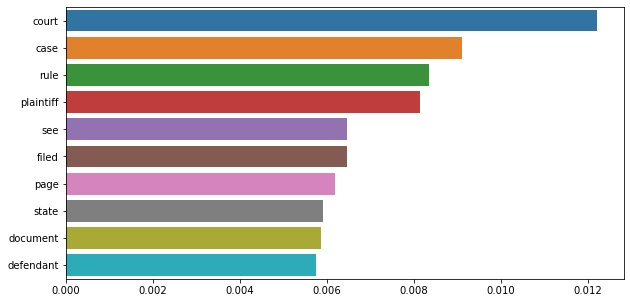

Top words for Topic #4:
{'project': 0.012516376, 'impact': 0.009967985, 'would': 0.005684671, 'environmental': 0.005535518, 'action': 0.0054888814, 'agency': 0.0052043074, 'case': 0.004537054, 'area': 0.004530421, 'page': 0.0044713444, 'document': 0.004287028}


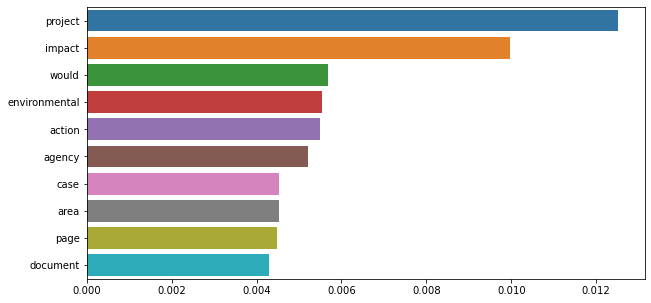

Top words for Topic #5:
{'climate': 0.014668553, 'change': 0.0085674245, 'fuel': 0.005901147, 'fossil': 0.0057201646, 'http': 0.005603575, 'gas': 0.0052850815, 'emission': 0.004892983, 'defendant': 0.0047865296, 'page': 0.004612184, 'global': 0.0044306186}


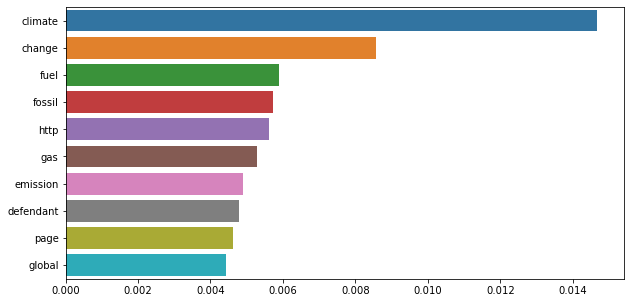

Top words for Topic #6:
{'email': 0.014888809, 'court': 0.013383455, 'llp': 0.010497425, 'case': 0.010366948, 'defendant': 0.00985755, 'telephone': 0.009829494, 'pro': 0.009689008, 'vice': 0.009549741, 'hac': 0.009547169, 'street': 0.009336361}


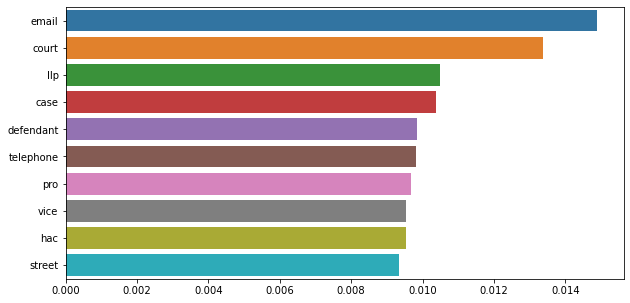

Top words for Topic #7:
{'gas': 0.009320734, 'project': 0.00897695, 'case': 0.0082033565, 'commission': 0.00781412, 'ferc': 0.007695053, 'page': 0.0068122945, 'filed': 0.005795219, 'state': 0.0053786347, 'document': 0.0048464322, 'pipeline': 0.0048345965}


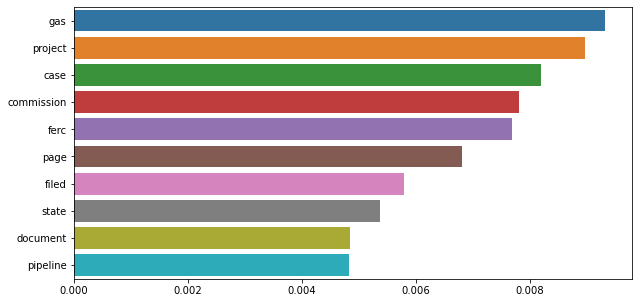

Top words for Topic #8:
{'document': 0.009226549, 'case': 0.0070857047, 'defendant': 0.006747227, 'court': 0.006335904, 'request': 0.0061614728, 'state': 0.004684802, 'page': 0.004509848, 'change': 0.0042284844, 'climate': 0.004223663, 'filed': 0.0039372505}


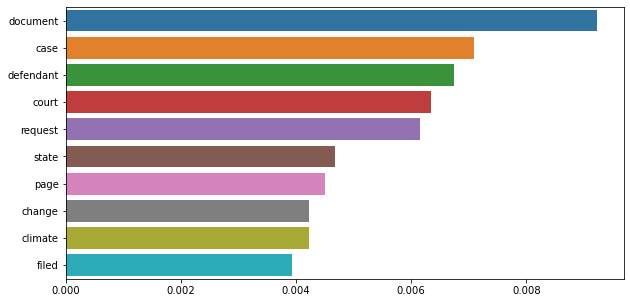

Top words for Topic #9:
{'federal': 0.016180756, 'court': 0.0125266565, 'claim': 0.010983626, 'law': 0.010655741, 'state': 0.010527291, 'case': 0.010225789, 'defendant': 0.008763141, 'see': 0.006968973, 'plaintiff': 0.006408844, 'f3d': 0.0052642645}


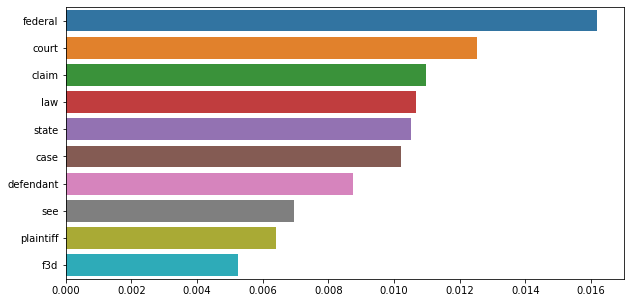

Top words for Topic #10:
{'case': 0.013101339, 'court': 0.010411674, 'filed': 0.0090920385, 'page': 0.0086588655, 'document': 0.008352852, 'agency': 0.008085396, 'state': 0.0073625017, 'federal': 0.007036613, 'plaintiff': 0.006965827, 'see': 0.006703074}


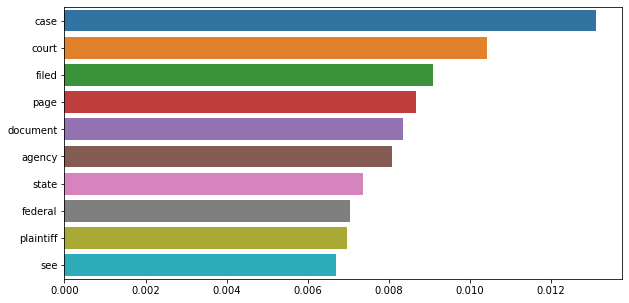

Year: 2023.0
Top words for Topic #1:
{'health': 0.0098522995, 'habitat': 0.008967605, 'case': 0.008865321, 'critical': 0.00863945, 'page': 0.0076981666, 'air': 0.0075701512, 'climate': 0.0072131827, 'seal': 0.0069688535, 'change': 0.006798833, 'filed': 0.005516657}


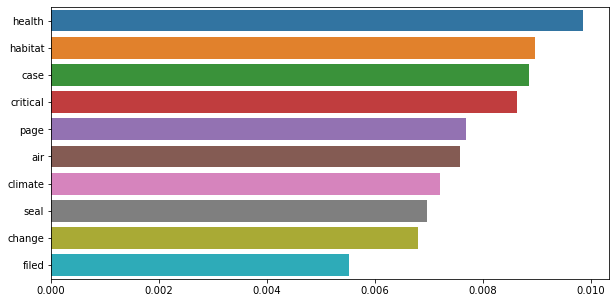

Top words for Topic #2:
{'court': 0.01910436, 'federal': 0.018498609, 'state': 0.012239718, 'law': 0.011772461, 'claim': 0.011756931, 'case': 0.010211538, 'defendant': 0.007333886, 'see': 0.0072522033, 'plaintiff': 0.0070311306, 'cir': 0.0059924047}


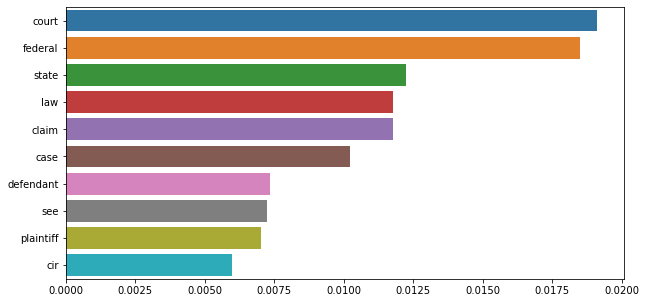

Top words for Topic #3:
{'state': 0.009259996, 'gas': 0.008940155, 'energy': 0.0071323286, 'climate': 0.0064076995, 'case': 0.0059414655, 'city': 0.0058312537, 'new': 0.005590818, 'oil': 0.005404538, 'pipeline': 0.005388313, 'page': 0.004940796}


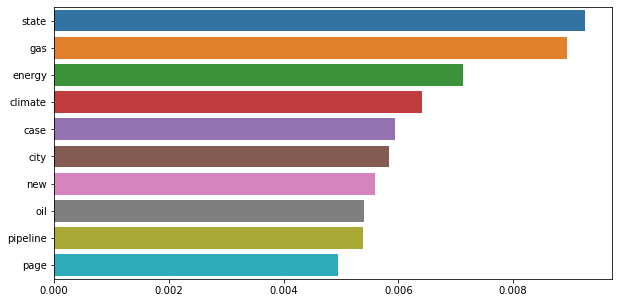

Top words for Topic #4:
{'project': 0.009440358, 'impact': 0.0073848576, 'gas': 0.0062045753, 'environmental': 0.0060608955, 'document': 0.005389092, 'filed': 0.0050113667, 'eir': 0.004459876, 'case': 0.004375783, 'would': 0.0043340484, 'page': 0.004288454}


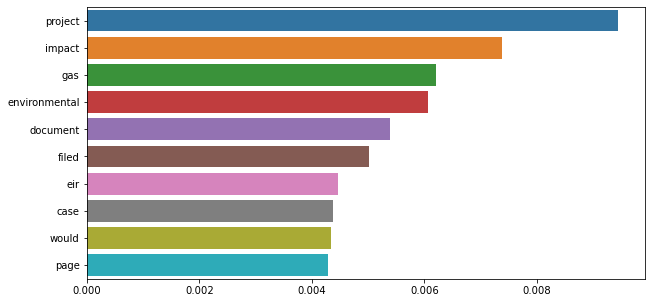

Top words for Topic #5:
{'case': 0.0099359555, 'project': 0.009300934, 'court': 0.007006749, 'page': 0.006731014, 'state': 0.006590426, 'would': 0.005874703, 'forest': 0.0052573076, 'impact': 0.005213417, 'alternative': 0.005153144, 'see': 0.0043827677}


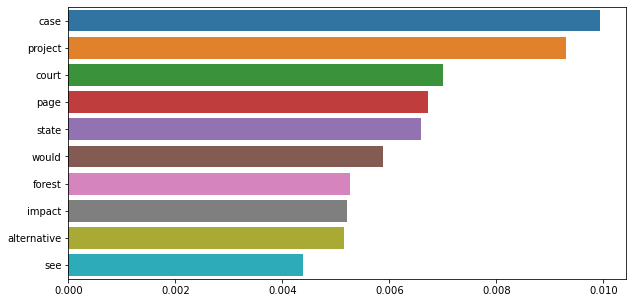

Top words for Topic #6:
{'standard': 0.017130947, 'section': 0.014484965, 'emission': 0.012839939, 'epa': 0.0115178935, 'waiver': 0.010298762, 'california': 0.009968073, 'vehicle': 0.008412898, 'disclosure': 0.0066646854, 'regulation': 0.0065185865, 'would': 0.006175356}


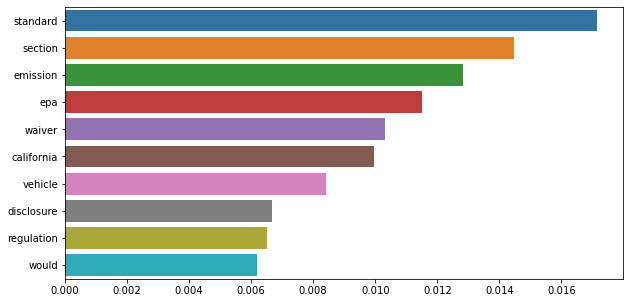

Top words for Topic #7:
{'case': 0.00907624, 'filed': 0.0069340183, 'document': 0.0067649246, 'page': 0.0066168257, 'agency': 0.0061182748, 'state': 0.0056246785, 'action': 0.0049738465, 'emission': 0.0049591376, 'see': 0.0049256943, 'court': 0.004754155}


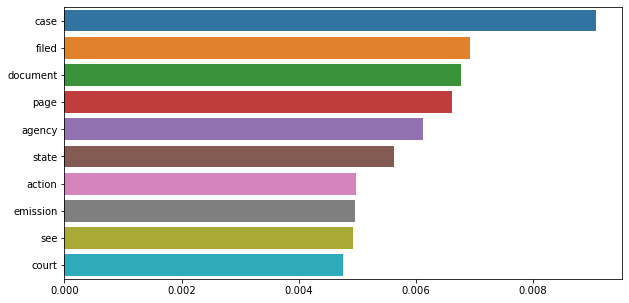

Top words for Topic #8:
{'rule': 0.008670874, 'state': 0.008144334, 'filed': 0.0065409164, 'case': 0.0064297747, 'page': 0.0060549765, 'see': 0.005950153, 'document': 0.0059348787, 'service': 0.005652004, 'investment': 0.005517105, 'form': 0.0054285284}


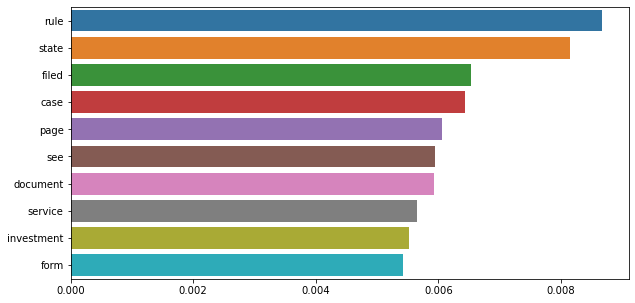

Top words for Topic #9:
{'climate': 0.011498708, 'emission': 0.007651463, 'nâ°': 0.0067490623, 'carbon': 0.0066528157, 'piã¨ce': 0.005946516, 'bnp': 0.005876015, 'company': 0.0057761697, 'paribas': 0.0056004277, 'risk': 0.0051729726, 'fossil': 0.005165224}


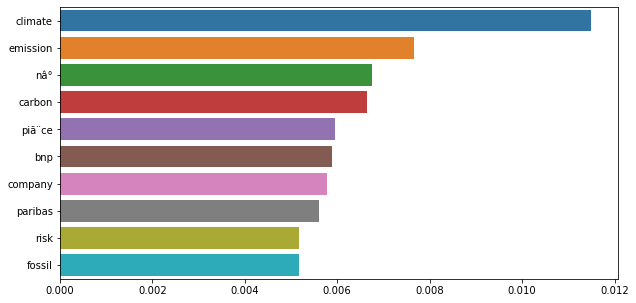

Top words for Topic #10:
{'i255': 0.073157616, 'gas': 0.010419752, 'project': 0.008878453, 'filed': 0.008744016, 'new': 0.008723713, 'commission': 0.007793136, 'jersey': 0.0071159033, 'document': 0.0067171277, 'ferc': 0.0066140066, 'order': 0.0058702505}


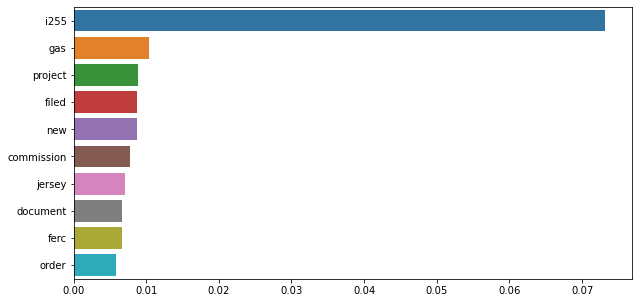

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot top words for each topic
def plot_top_words(lda, num_words=10):
    for i, topic in enumerate(lda.show_topics(formatted=False, num_topics=-1, num_words=num_words)):
        topic_words = dict(topic[1])
        print(f"Top words for Topic #{i + 1}:")
        print(topic_words)
        
        plt.figure(figsize=(10, 5))
        sns.barplot(x=list(topic_words.values()), y=list(topic_words.keys()))
        plt.show()

# Plotting top words for each topic for each year
for year, lda in lda_models.items():
    print(f"Year: {year}")
    plot_top_words(lda)
